I() 里面是作为整体，进行回归.I是一个函数，有了I确实只需要一个【】

In [1]:
%%capture
!pip install linearmodels

In [2]:
#引包：引入所需python包
import xlrd
import os
import re
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

from sklearn.metrics import roc_curve,auc
import matplotlib as mpl
from matplotlib import pyplot as plt
from numpy import nan
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import time
from collections import Counter   #引入Counter
from linearmodels import IV3SLS
from scipy.stats import kstest
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# 数据源
## eviews数据

In [3]:
dir = r"./data/"
print(os.listdir(dir))  

['【20200703】-预测误差(2015-2017).xls', '【20200703】-模拟（2016，10）-3.xls', '【20200703】-模拟（2016，6-8）-2.xls', '【20200703】-模拟（2016,1-4）-1.xls', '其它数据.csv', '.ipynb_checkpoints', 'alleviewsdata.xlsx', '方程描述.csv']


In [4]:
file = "alleviewsdata.xlsx"
data_ev= pd.read_excel(dir+file,"Sheet1",index_col = 0 ,na_values=['9999'])
data_ev.columns = data_ev.columns.str.lower()
data_ev.columns

Index(['con_fn_bj', 'con_fn_bj_0', 'con_fn_bj_1', 'con_fn_bj_10',
       'con_fn_bj_2', 'con_fn_bj_3', 'con_fn_bj_4', 'con_fn_bj_5',
       'con_fn_bj_6', 'con_fn_bj_7',
       ...
       'yht_un_tj_1', 'yht_un_tj_10', 'yht_un_tj_2', 'yht_un_tj_3',
       'yht_un_tj_4', 'yht_un_tj_5', 'yht_un_tj_6', 'yht_un_tj_7',
       'yht_un_tj_8', 'yht_un_tj_9'],
      dtype='object', length=3722)

## 方程式描述

In [5]:
# 方程式的自变量，因变量
eq_disc = pd.read_csv(dir+"方程描述.csv")
eq_disc.head(2)

,ID,type,y
0,Eq1,行为,gdp1r_bj
1,Eq2,定义方程,gdpn_bj


In [6]:
len(set(list(eq_disc["y"])))

284

In [7]:

b = dict(Counter(list(eq_disc["y"])))
print ({key:value for key,value in b.items()if value > 1})  #展现重复元素和重复次数 

{}


# 变量

In [8]:
allvariables = ["con_fn_bj","con_fn_hb","con_fn_tj","con_fr_bj","con_fr_tj","con_gn_bj","con_gn_tj","con_gr_bj","con_gr_tj","con_pn_bj","con_pn_tj","con_pr_bj","con_pr_tj","con_prn_bj","con_prn_tj","con_prr_bj","con_prr_tj","con_pun_bj","con_pun_tj","con_pur_bj","con_pur_tj","cone_rn_bj","cone_rn_hb","cone_rn_tj","cone_un_bj","cone_un_hb","cone_un_tj","conet_rn_bj","conet_rn_hb","conet_rn_tj","conet_un_bj","conet_un_hb","conet_un_tj","consn_bj","consn_hb","consn_tj","consr_bj","consr_hb","consr_tj","cpi_bj","cpi_hb","cpi_tj","cul_area_bj","cul_area_tj","d_con_prr_tj","d_cone_rn_bj","d_cone_rn_tj","d_consn_bj","d_consn_tj","d_cpi_bj","d_cpi_tj","d_dep_san_bj","d_dep_san_hb","d_dep_san_tj","d_depn_bj","d_depn_hb","d_depn_tj","d_emp2_hb","d_emp2_tj","d_emp3_bj","d_emp3_hb","d_emp3_tj","d_exusd_bj","d_exusd_tj","d_faipi_bj","d_fen_bj2","d_fen_hb_1","d_fen_tj1","d_fen_tj2","d_frn_hb","d_frn_tj","d_gdp1d_hb","d_gdp1d_tj","d_gdp1r_bj","d_gdp2_airn_tj","d_gdp2_bindar_hb","d_gdp2_bindar_tj","d_gdp2_birn_tj","d_gdp2_caln_tj","d_gdp2_emin_hb","d_gdp2_emin_tj","d_gdp2_epin_tj","d_gdp2_hemin_tj","d_gdp2_indar_bj","d_gdp2_indar_hb","d_gdp2_indar_tj","d_gdp2_mecn_tj","d_gdp2_medn_tj","d_gdp2_necin_tj","d_gdp2_nmin_tj","d_gdp2_tecn_hb_1","d_gdp2_tecn_hb_2","d_gdp2_tecn_tj_1","d_gdp2_tecn_tj_2","d_gdp2_tran_tj","d_gdp2d_bj","d_gdp2d_hb","d_gdp2d_tj","d_gdp2r_bj_1","d_gdp2r_hb_1","d_gdp2r_tj_1","d_gdp3_fian_hb","d_gdp3_infn_hb","d_gdp3_infwn_tj","d_gdp3_rean_bj","d_gdp3_renn_hb","d_gdp3_renn_tj","d_gdp3_sicn_hb","d_gdp3_sicn_tj","d_gdp3_tspan_tj","d_gdp3_wran_hb","d_gdp3_wran_tj","d_gdp3r_hb","d_gdp3r_tj","d_gdp_infn_bj","d_gdp_mosn_bj","d_gdp_tecn_bj","d_gdp_tran_bj","d_imusd_bj","d_imusd_hb","d_imusd_tj","d_investr_bj","d_investr_tj","d_loann_bj","d_nex_gsr_bj","d_nex_gsr_tj","d_popu_bj","d_ppi_bj","d_ppi_hb","d_ppi_tj","d_rpi_bj","d_tax_cinn_hb","d_tax_pinn_hb","d_tax_pinn_tj","d_tax_vadn_bj","d_tax_vadn_hb","d_tax_vadn_tj","d_taxn_bj_1","d_taxn_hb_1","d_taxn_hb_2","d_taxn_tj_1","d_taxn_tj_2","d_totemp_bj","d_totpop_bj","d_totpop_tj","d_tta_bj","d_tta_hb","d_tta_tj","d_yht_un_hb","dep_san_bj","dep_san_hb","dep_san_tj","depn_bj","depn_hb","depn_tj","emp1_bj","emp1_hb","emp1_tj","emp2_bj","emp2_bj_a","emp2_hb","emp2_tj","emp3_bj","emp3_hb","emp3_tj","exrate_cn","exusd_bj","exusd_ch","exusd_hb","exusd_tj","faipi_bj","faipi_hb","faipi_tj","fe_culn_bj","fe_culn_hb","fe_culn_tj","fe_edun_bj","fe_edun_hb","fe_edun_tj","fe_eepn_bj","fe_eepn_hb","fe_eepn_tj","fe_medn_bj","fe_medn_hb","fe_medn_tj","fe_ssen_bj","fe_ssen_hb","fe_ssen_tj","fe_tecn_bj","fe_tecn_hb","fe_tecn_tj","fen_bj","fen_bj1","fen_bj2","fen_hb","fen_hb1","fen_hb2","fen_tj","fen_tj1","fen_tj2","frn_bj","frn_hb","frn_tj","gdp1d_bj","gdp1d_hb","gdp1d_tj","gdp1n_bj","gdp1n_hb","gdp1n_tj","gdp1r_bj","gdp1r_hb","gdp1r_tj","gdp2_airn_tj","gdp2_bindad_bj","gdp2_bindad_hb","gdp2_bindad_tj","gdp2_bindan_bj","gdp2_bindan_hb","gdp2_bindan_tj","gdp2_bindar_bj","gdp2_bindar_hb","gdp2_bindar_tj","gdp2_birn_tj","gdp2_caln_tj","gdp2_emin_hb","gdp2_emin_tj","gdp2_emin_tj_a","gdp2_emir_hb","gdp2_epin_tj","gdp2_hemin_tj","gdp2_hemin_tj_a","gdp2_indad_bj","gdp2_indad_hb","gdp2_indad_tj","gdp2_indan_bj","gdp2_indan_hb","gdp2_indan_tj","gdp2_indar_bj","gdp2_indar_hb","gdp2_indar_tj","gdp2_mecn_tj","gdp2_medn_tj","gdp2_medn_tj_a","gdp2_necin_tj","gdp2_necin_tj_a","gdp2_nein_tj","gdp2_nmin_tj","gdp2_tecn_hb","gdp2_tecn_hb1","gdp2_tecn_hb2","gdp2_tecn_tj","gdp2_tecn_tj1","gdp2_tecn_tj2","gdp2_tecr_hb","gdp2_tran_tj","gdp2d_bj","gdp2d_hb","gdp2d_tj","gdp2n_bj","gdp2n_hb","gdp2n_tj","gdp2r_bj","gdp2r_bj1","gdp2r_bj2","gdp2r_erro_bj","gdp2r_erro_hb","gdp2r_erro_tj","gdp2r_hb","gdp2r_hb1","gdp2r_hb2","gdp2r_tj","gdp2r_tj1","gdp2r_tj2","gdp3_fian_bj","gdp3_fian_hb","gdp3_fian_tj","gdp3_fiar_bj","gdp3_fiar_tj","gdp3_infn_bj","gdp3_infn_hb","gdp3_infn_tj","gdp3_infr_bj","gdp3_infr_tj","gdp3_infwn_tj","gdp3_rean_bj","gdp3_rean_hb","gdp3_rean_tj","gdp3_rear_bj","gdp3_rear_tj","gdp3_renn_bj","gdp3_renn_hb","gdp3_renn_tj","gdp3_renr_bj","gdp3_renr_tj","gdp3_sicn_bj","gdp3_sicn_hb","gdp3_sicn_tj","gdp3_sicr_bj","gdp3_sicr_tj","gdp3_tragt_bj","gdp3_tragt_hb","gdp3_trapt_bj","gdp3_trapt_hb","gdp3_trapt_tj","gdp3_tratp_bj","gdp3_tratp_tj","gdp3_tspan_bj","gdp3_tspan_hb","gdp3_tspan_tj","gdp3_tspar_bj","gdp3_tspar_tj","gdp3_wran_bj","gdp3_wran_hb","gdp3_wran_tj","gdp3_wrar_bj","gdp3_wrar_tj","gdp3d_bj","gdp3d_hb","gdp3d_tj","gdp3d_tj_a","gdp3n_bj","gdp3n_hb","gdp3n_tj","gdp3r_bj","gdp3r_hb","gdp3r_tj","gdp_infn_bj","gdp_momn_bj","gdp_mosn_bj","gdp_tecn_bj","gdp_tran_bj","gdpd_bj","gdpd_hb","gdpd_tj","gdpen_bj","gdpen_hb","gdpen_tj","gdper_bj","gdper_hb","gdper_tj","gdpn_bj","gdpn_hb","gdpn_tj","gdpr_bj","gdpr_hb","gdpr_tj","imusd_bj","imusd_hb","imusd_tj","intratel_cn","inv_chn_bj","inv_chn_tj","inv_chr_bj","inv_chr_tj","inv_fin_bj","inv_fin_tj","inv_fir_bj","inv_fir_tj","inv_fon_bj","inv_fon_hb","inv_fon_tj","inv_for_bj","inv_for_tj","inv_rean_bj","inv_rean_hb","inv_rean_tj","investn_bj","investn_hb","investn_tj","investr_bj","investr_hb","investr_tj","loan_ln_bj","loan_ln_hb","loan_ln_tj","loann_bj","loann_hb","loann_tj","lse_bj","lse_hb","lse_tj","nex_gsn_bj","nex_gsn_hb","nex_gsn_tj","nex_gsr_bj","nex_gsr_bj_a","nex_gsr_tj","nex_gsr_tj_a","pcon_gd_bj","pcon_gd_tj","pcon_prd_bj","pcon_prd_tj","pcon_pud_bj","pcon_pud_tj","pgdp2_emin_hb","pgdp2_tecd_hb","pgdp3_fiad_bj","pgdp3_fiad_tj","pgdp3_infd_bj","pgdp3_infd_tj","pgdp3_read_bj","pgdp3_read_tj","pgdp3_rend_bj","pgdp3_rend_tj","pgdp3_sicd_bj","pgdp3_sicd_tj","pgdp3_tspad_bj","pgdp3_tspad_tj","pgdp3_wrad_bj","pgdp3_wrad_tj","pinv_chd_bj","pinv_chd_tj","pinv_fid_bj","pinv_fid_tj","pinv_fod_bj","pinv_fod_tj","pnex_gsd_bj","pnex_gsd_tj","popr_bj","popr_hb","popr_tj","popr_tj_a","popu_bj","popu_hb","popu_tj","ppi_bj","ppi_hb","ppi_tj","rpi_bj","rpi_hb","rpi_tj","tax_cinn_bj","tax_cinn_hb","tax_cinn_tj","tax_pinn_bj","tax_pinn_hb","tax_pinn_tj","tax_vadn_bj","tax_vadn_hb","tax_vadn_tj","taxn_bj","taxn_bj1","taxn_bj2","taxn_hb","taxn_hb1","taxn_hb2","taxn_tj","taxn_tj1","taxn_tj2","totemp_bj","totemp_hb","totemp_tj","totpop_bj","totpop_hb","totpop_tj","tta_bj","tta_f_bj","tta_hb","tta_tj","yh_rn_bj","yh_rn_hb","yh_rn_tj","yh_un_bj","yh_un_hb","yh_un_tj","yhn_bj","yhn_hb","yhn_tj","yht_n_bj","yht_n_hb","yht_n_tj","yht_rn_bj","yht_rn_hb","yht_rn_tj"]
allvariables = [x.lower() for x in allvariables]
allvariables = [x for x in allvariables if x != ""]
len(allvariables)

474

## 284 内生变量

内生变量外生变量符号写错了

In [9]:
exogs_all = ["GDP1R_BJ","GDPn_bj","GDPr_bj","GDP1n_bj","GDP2_indaN_bj","gdp2_bindan_bj","GDP2N_bj","GDP2R_bj2","gdp2r_bj1","gdp2r_bj","GDP3N_bj","GDP2_INDAR_BJ","GDP2_BINDAR_BJ","GDP3R_BJ","con_fR_bj","con_gR_bj","con_pR_bj","con_fN_bj","con_pN_bj","con_puN_bj","con_prN_bj","con_gn_bj","investN_bj","inv_foN_bj","inv_chN_bj","consR_bj","inv_foR_bj","inv_fiN_bj","GDPeR_bj","GDPeN_bj","nex_gsN_bj","CON_PUR_BJ","CON_PRR_BJ","INVESTR_BJ","INV_FIR_BJ","NEX_GSR_BJ","CONSN_BJ","EXUSD_BJ","IMUSD_BJ","yht_N_bj","yh_uN_bj","yh_rN_bj","yhN_bj","conet_uN_bj","conet_rN_bj","YHT_UN_BJ","YHT_RN_BJ","CONE_UN_BJ","CONE_RN_BJ","FRN_BJ","TAXN_BJ_1","TAXN_BJ_2","taxn_bj","TAX_VADN_BJ","TAX_CINN_BJ","TAX_PINN_BJ","FEN_BJ_1","FEN_BJ_2","feN_bj","DEPN_BJ","DEP_SAN_BJ","LOAN_LN_BJ","LOANN_BJ","emp1_bj","POPR_bj","TOTEMP_BJ","EMP2_BJ","","EMP3_BJ","TOTPOP_BJ","POPU_BJ","RPI_BJ","CPI_BJ","GDP1D_BJ","GDP2D_BJ","GDP3D_BJ","GDPD_BJ","PPI_BJ","FAIPI_BJ","gdp3_tspaR_bj","GDP3_TSPAN_BJ","gdp3_wrar_bj","GDP3_WRAN_BJ","gdp3_fiar_bj","GDP3_FIAN_BJ","gdp3_rear_bj","GDP3_REAN_BJ","gdp3_infr_bj","GDP3_INFN_BJ","gdp3_renr_bj","GDP3_RENN_BJ","gdp3_sicr_bj","GDP3_SICN_BJ","GDP_TRAN_BJ","GDP_TECN_BJ","TTA_F_BJ","GDP_MOSN_BJ","gdp_momn_bj","GDP_INFN_BJ","tta_bj","GDP1R_TJ","GDPn_tj","GDPr_tj","GDP1n_tj","GDP2_indaN_tj","gdp2_bindan_tj","GDP2N_tj","GDP2R_tj2","gdp2r_tj_1","gdp2r_tj","GDP3N_tj","GDP2_INDAR_TJ","GDP2_BINDAR_TJ","GDP3R_TJ","con_fR_tj","con_gR_tj","con_pR_tj","con_fN_tj","con_pN_tj","con_puN_tj","con_prN_tj","con_gn_tj","investN_tj","inv_foN_tj","inv_chN_tj","consR_tj","inv_foR_tj","inv_fiN_tj","GDPeR_tj","GDPeN_tj","nex_gsN_tj","CON_PUR_TJ","CON_PRR_TJ","INVESTR_TJ","INV_FIR_TJ","NEX_GSR_TJ","","CONSN_TJ","EXUSD_TJ","IMUSD_TJ","yht_N_tj","yh_uN_tj","yh_rN_tj","yhN_tj","conet_uN_tj","conet_rN_tj","YHT_UN_TJ","YHT_RN_TJ","CONE_UN_TJ","CONE_RN_TJ","FRN_TJ","TAXN_TJ_1","TAXN_TJ_2","taxn_tj","TAX_VADN_TJ","TAX_CINN_TJ","TAX_PINN_TJ","FEN_TJ_1","FEN_TJ_2","feN_tj","DEPN_TJ","DEP_SAN_TJ","LOAN_LN_TJ","LOANN_TJ","emp1_tj","POPR_tj","","TOTEMP_TJ","EMP2_TJ","EMP3_TJ","TOTPOP_TJ","POPU_TJ","RPI_TJ","CPI_TJ","GDP1D_TJ","GDP2D_TJ","GDP3D_TJ","","GDPD_TJ","PPI_TJ","FAIPI_TJ","gdp3_tspaR_tj","GDP3_TSPAN_TJ","gdp3_wrar_tj","GDP3_WRAN_TJ","gdp3_fiar_tj","GDP3_FIAN_TJ","gdp3_rear_tj","GDP3_REAN_TJ","gdp3_infr_tj","GDP3_INFN_TJ","gdp3_renr_tj","GDP3_RENN_TJ","gdp3_sicr_tj","GDP3_SICN_TJ","GDP2_TECN_TJ_1","GDP2_TECN_TJ_2","GDP2_TECN_TJ","GDP2_MEDN_TJ","","TTA_TJ","GDP2_AIRN_TJ","GDP2_CALN_TJ","GDP2_MECN_TJ","GDP2_EMIN_TJ","GDP2_TRAN_TJ","GDP3_INFWN_TJ","GDP2_HEMIN_TJ","","GDP2_NMIN_TJ","GDP2_BIRN_TJ","GDP2_NECIN_TJ","","GDP2_NEIN_TJ","GDP2_EPIN_TJ","GDP1R_HB","GDPn_hb","GDPr_hb","GDP1n_hb","GDP2_indaN_hb","gdp2_bindan_hb","GDP2N_hb","GDP2R_hb2","gdp2r_hb_1","gdp2r_hb","GDP3N_hb","GDP2_INDAR_HB","GDP2_BINDAR_HB","GDP3R_HB","investN_hb","consR_hb","GDPeR_hb","GDPeN_hb","con_fn_hb","INVESTR_HB","CONSN_HB","EXUSD_HB","IMUSD_HB","yht_N_hb","yh_uN_hb","yh_rN_hb","yhN_hb","conet_uN_hb","conet_rN_hb","YHT_UN_HB","YHT_RN_HB","CONE_UN_HB","CONE_RN_HB","FRN_HB","TAXN_HB_1","TAXN_HB_2","taxn_hb","TAX_VADN_HB","TAX_CINN_HB","TAX_PINN_HB","FEN_HB_1","FEN_HB_2","feN_hb","DEPN_HB","DEP_SAN_HB","LOAN_LN_HB","LOANN_HB","emp1_hb","POPR_hb","TOTEMP_HB","EMP2_HB","EMP3_HB","TOTPOP_HB","POPU_HB","RPI_HB","CPI_HB","GDP1D_HB","GDP2D_HB","GDP3D_HB","GDPD_HB","PPI_HB","FAIPI_HB","GDP3_TSPAN_HB","GDP3_WRAN_HB","GDP3_FIAN_HB","GDP3_REAN_HB","GDP3_INFN_HB","GDP3_RENN_HB","GDP3_SICN_HB","GDP2_TECN_HB_1","GDP2_TECN_HB_2","gdp2_tecn_hb","TTA_HB","gdp2_tecR_hb","GDP2_EMIN_HB","gdp2_emiR_hb"]
exogs_all = [x.lower() for x in exogs_all]
exogs_all = [x for x in exogs_all if x != ""]
len(exogs_all)

284

In [10]:
exogs_all = [x.replace("bj_1","bj1") for x in exogs_all  ]
exogs_all = [x.replace("bj_2","bj2") for x in exogs_all  ]
exogs_all = [x.replace("hb_1","hb1") for x in exogs_all  ]
exogs_all = [x.replace("hb_2","hb2") for x in exogs_all  ]
exogs_all = [x.replace("tj_1","tj1") for x in exogs_all  ]
exogs_all = [x.replace("tj_2","tj2") for x in exogs_all  ]
exogs_all

['gdp1r_bj',
 'gdpn_bj',
 'gdpr_bj',
 'gdp1n_bj',
 'gdp2_indan_bj',
 'gdp2_bindan_bj',
 'gdp2n_bj',
 'gdp2r_bj2',
 'gdp2r_bj1',
 'gdp2r_bj',
 'gdp3n_bj',
 'gdp2_indar_bj',
 'gdp2_bindar_bj',
 'gdp3r_bj',
 'con_fr_bj',
 'con_gr_bj',
 'con_pr_bj',
 'con_fn_bj',
 'con_pn_bj',
 'con_pun_bj',
 'con_prn_bj',
 'con_gn_bj',
 'investn_bj',
 'inv_fon_bj',
 'inv_chn_bj',
 'consr_bj',
 'inv_for_bj',
 'inv_fin_bj',
 'gdper_bj',
 'gdpen_bj',
 'nex_gsn_bj',
 'con_pur_bj',
 'con_prr_bj',
 'investr_bj',
 'inv_fir_bj',
 'nex_gsr_bj',
 'consn_bj',
 'exusd_bj',
 'imusd_bj',
 'yht_n_bj',
 'yh_un_bj',
 'yh_rn_bj',
 'yhn_bj',
 'conet_un_bj',
 'conet_rn_bj',
 'yht_un_bj',
 'yht_rn_bj',
 'cone_un_bj',
 'cone_rn_bj',
 'frn_bj',
 'taxn_bj1',
 'taxn_bj2',
 'taxn_bj',
 'tax_vadn_bj',
 'tax_cinn_bj',
 'tax_pinn_bj',
 'fen_bj1',
 'fen_bj2',
 'fen_bj',
 'depn_bj',
 'dep_san_bj',
 'loan_ln_bj',
 'loann_bj',
 'emp1_bj',
 'popr_bj',
 'totemp_bj',
 'emp2_bj',
 'emp3_bj',
 'totpop_bj',
 'popu_bj',
 'rpi_bj',
 'cpi_bj',
 '

In [11]:
#测试 ： 外生变量清单和方程式的y值对应上了
[x for x in list(eq_disc["y"]) if x not in exogs_all]

[]

<font  color="blue" size =4>没有重复的内生变量 </font>

In [12]:
b = dict(Counter(exogs_all))
print ({key:value for key,value in b.items()if value > 1})  #展现重复元素和重复次数 

{}


<font  color="blue" size =4>各地区数量正确： </font>

In [13]:
print ("北京的内生变量数量 ok ： " , len([x for x in exogs_all if "_bj" in  x]))
print ("天津的内生变量数量 ： " , len([x for x in exogs_all if "_tj" in  x]))
print ("河北的内生变量数量 ： " , len([x for x in exogs_all if "_hb" in  x]))

北京的内生变量数量 ok ：  99
天津的内生变量数量 ：  109
河北的内生变量数量 ：  76


In [14]:
exogs_bj = [x for x in exogs_all if "_bj" in x ]
exogs_tj = [x for x in exogs_all if "_tj" in  x]
exogs_hb = [x for x in exogs_all if "_hb" in  x]

# 准备
## 方程ID

In [15]:
Eqlist = ["Eq"+str(i+1) for i in range(284)]
Eqlist

['Eq1',
 'Eq2',
 'Eq3',
 'Eq4',
 'Eq5',
 'Eq6',
 'Eq7',
 'Eq8',
 'Eq9',
 'Eq10',
 'Eq11',
 'Eq12',
 'Eq13',
 'Eq14',
 'Eq15',
 'Eq16',
 'Eq17',
 'Eq18',
 'Eq19',
 'Eq20',
 'Eq21',
 'Eq22',
 'Eq23',
 'Eq24',
 'Eq25',
 'Eq26',
 'Eq27',
 'Eq28',
 'Eq29',
 'Eq30',
 'Eq31',
 'Eq32',
 'Eq33',
 'Eq34',
 'Eq35',
 'Eq36',
 'Eq37',
 'Eq38',
 'Eq39',
 'Eq40',
 'Eq41',
 'Eq42',
 'Eq43',
 'Eq44',
 'Eq45',
 'Eq46',
 'Eq47',
 'Eq48',
 'Eq49',
 'Eq50',
 'Eq51',
 'Eq52',
 'Eq53',
 'Eq54',
 'Eq55',
 'Eq56',
 'Eq57',
 'Eq58',
 'Eq59',
 'Eq60',
 'Eq61',
 'Eq62',
 'Eq63',
 'Eq64',
 'Eq65',
 'Eq66',
 'Eq67',
 'Eq68',
 'Eq69',
 'Eq70',
 'Eq71',
 'Eq72',
 'Eq73',
 'Eq74',
 'Eq75',
 'Eq76',
 'Eq77',
 'Eq78',
 'Eq79',
 'Eq80',
 'Eq81',
 'Eq82',
 'Eq83',
 'Eq84',
 'Eq85',
 'Eq86',
 'Eq87',
 'Eq88',
 'Eq89',
 'Eq90',
 'Eq91',
 'Eq92',
 'Eq93',
 'Eq94',
 'Eq95',
 'Eq96',
 'Eq97',
 'Eq98',
 'Eq99',
 'Eq100',
 'Eq101',
 'Eq102',
 'Eq103',
 'Eq104',
 'Eq105',
 'Eq106',
 'Eq107',
 'Eq108',
 'Eq109',
 'Eq110',
 'Eq111'

## 转换函数

In [16]:
def diff(var , n ,m ) :
    return var.shift(n) -var.shift(m)

def gdp2gdp3tax( col1,col2,col3):  #Eq46
    return col1 + col2 - col3
#例子 ： diff("gdp1r_bj",0,1),diff("gdp1r_bj",1,2)

def fen_sum(col1,col2,col3,col4,col5,col6) : #Eq58
    return col1 + col2 + col3 + col4 + col5 + col6

def lagsum(var , n ,m) :
    return var.shift(n) + var.shift(m)

def pch(var):
    return  (var - var.shift(1) )/  var.shift(1) 

def prd (var1,var2)  :                   #Eq47
    return var1*var2 /100

def pchnm(var ,n,m) :
    return (var.shift(n) - var.shift(m))/var.shift(m)

def gdp2_tecn_sum (var1,var2,var3) :  #Eq217  gdp2_tecn (gdp2_tecn_hb1,gdp2_tecn_hb2,gdp2d_hb)
    return ((var1+var2)/2)/var3.shift(1)
#[gdp2_tecn_hb/gdp2d_hb.shift(1)  ~ I((gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2)/gdp2d_hb.shift(1)]

## 填充缺失值

场景是2016年左右，所以以此为特征进行补充，更优

In [17]:
# Eq93  北京
data_ev.loc[2014 , "gdp_tran_bj"] = data_ev.loc[2015,"gdp_tran_bj"] -  ((data_ev.loc[2015,"gdp_tecn_bj"] - data_ev.loc[2014,"gdp_tecn_bj"]) /data_ev.loc[2015,"gdp_tecn_bj"])* data_ev.loc[2015,"gdp_tran_bj"] # 线性回归结果
data_ev.loc[2013 , "gdp_tran_bj"] = data_ev.loc[2014,"gdp_tran_bj"] -  ((data_ev.loc[2014,"gdp_tecn_bj"] - data_ev.loc[2013,"gdp_tecn_bj"]) /data_ev.loc[2014,"gdp_tecn_bj"])* data_ev.loc[2014,"gdp_tran_bj"] # 线性回归结果
data_ev.loc[2012 , "gdp_tran_bj"] = data_ev.loc[2013,"gdp_tran_bj"] -  ((data_ev.loc[2013,"gdp_tecn_bj"] - data_ev.loc[2012,"gdp_tecn_bj"]) /data_ev.loc[2013,"gdp_tecn_bj"])* data_ev.loc[2013,"gdp_tran_bj"] # 线性回归结果
data_ev[["gdp_tran_bj","gdp_tecn_bj"]]


,gdp_tran_bj,gdp_tecn_bj
1996,NaN,NaN
1997,NaN,NaN
1998,NaN,NaN
1999,NaN,NaN
2000,NaN,NaN
2001,NaN,NaN
2002,NaN,NaN
2003,NaN,NaN
2004,NaN,370.600000
2005,NaN,504.400000


In [18]:
# Eq279  河北
data_ev.loc[2014 , "lse_hb"] = data_ev.loc[2015,"lse_hb"] -  ((data_ev.loc[2015,"gdp2_tecn_hb2"] - data_ev.loc[2014,"gdp2_tecn_hb2"]) /data_ev.loc[2015,"gdp2_tecn_hb2"])* data_ev.loc[2015,"lse_hb"] # 线性回归结果
data_ev[["lse_hb","gdp2_tecn_hb2"]]

,lse_hb,gdp2_tecn_hb2
1996,NaN,NaN
1997,NaN,NaN
1998,NaN,NaN
1999,NaN,NaN
2000,NaN,NaN
2001,NaN,NaN
2002,NaN,NaN
2003,NaN,NaN
2004,NaN,NaN
2005,NaN,NaN


## 定义方程
for i in range(99,208) :
    if eq_disc.iloc[i]["type"] != "行为" :
        print(eq_disc.iloc[i]["ID"] , " = " ,eq_disc.iloc[i]["y"], " ~ ")
        
### 北京

In [19]:
Eq2 = "gdpn_bj ~ gdp1n_bj + gdp2n_bj + gdp3n_bj "
Eq3 = " gdpr_bj ~ gdp1r_bj + gdp2r_bj + gdp3r_bj"
Eq4 = "gdp1n_bj ~ gdp1r_bj * gdp1d_bj / 100"
Eq5 = " gdp2_bindan_bj ~ gdp2_bindar_bj * gdp2_bindad_bj / 100"
Eq6 = "  gdp2_bindan_bj ~ gdp2_bindar_bj * gdp2_bindad_bj / 100"
Eq7 = "gdp2n_bj ~ gdp2r_bj * gdp2d_bj / 100"
Eq8 = "gdp2r_bj2 ~ gdp2_indar_bj + gdp2_bindar_bj + gdp2r_erro_bj"
Eq10 = "gdp2r_bj ~ (gdp2r_bj1 + gdp2r_bj2) / 2"
Eq11 = " gdp3n_bj ~ gdp3r_bj * gdp3d_bj / 100"
Eq15 = "con_fr_bj ~ con_pr_bj + con_gr_bj"
Eq16 = "con_gr_bj ~ con_gn_bj / pcon_gd_bj * 100"
Eq17 = " con_pr_bj ~ con_pur_bj + con_prr_bj"
Eq18 = "con_fn_bj ~ con_pn_bj + con_gn_bj"
Eq19 = "con_pn_bj ~ con_pun_bj + con_prn_bj"
Eq20 = "con_pun_bj ~ con_pur_bj * pcon_pud_bj / 100"
Eq21 = "con_prn_bj ~ con_prr_bj * pcon_prd_bj / 100"
Eq23 = "investn_bj ~ investr_bj * faipi_bj / 100"
Eq24 = "inv_fon_bj ~ inv_for_bj * pinv_fod_bj / 100"
Eq25 = "inv_chn_bj ~ inv_chr_bj * pinv_chd_bj / 100"
Eq26 = "consr_bj ~ consn_bj / rpi_bj * 100"
Eq27 = "inv_for_bj ~ inv_fir_bj + inv_chr_bj"
Eq28 = "inv_fin_bj ~ inv_fir_bj * pinv_fid_bj / 100"
Eq29 = "gdper_bj ~ con_fr_bj + inv_for_bj + nex_gsr_bj"
Eq30 = "gdpen_bj ~ con_fn_bj + inv_fon_bj + nex_gsn_bj"
Eq31 = "nex_gsn_bj ~ nex_gsr_bj * pnex_gsd_bj / 100"
Eq40 = "yht_n_bj ~ yht_rn_bj + yht_un_bj"
Eq41 = "yh_un_bj ~ yht_un_bj / popu_bj"
Eq42 = "yh_rn_bj ~ yht_rn_bj / popr_bj"
Eq43 = "yhn_bj ~ yht_n_bj / totpop_bj"
Eq44 = "conet_un_bj ~ cone_un_bj * popu_bj"
Eq45 = "conet_rn_bj ~ cone_rn_bj * popr_bj"
Eq53 = "taxn_bj ~ (taxn_bj1 + taxn_bj2) / 2"
Eq59 = "fen_bj ~ (fen_bj1 + fen_bj2)/2"
Eq64 = "emp1_bj ~ totemp_bj - emp2_bj - emp3_bj"
Eq65 = "popr_bj ~ totpop_bj - popu_bj"
Eq79 = "gdp3_tspar_bj ~ gdp3_tspan_bj / pgdp3_tspad_bj * 100"
Eq81 = "gdp3_wrar_bj ~ gdp3_wran_bj / pgdp3_wrad_bj * 100"
Eq83 = "gdp3_fiar_bj ~ gdp3_fian_bj / pgdp3_fiad_bj * 100"
Eq85 = "gdp3_rear_bj ~ gdp3_rean_bj / pgdp3_read_bj * 100"
Eq87 = "gdp3_infr_bj ~ gdp3_infn_bj / pgdp3_infd_bj * 100"
Eq89 = "gdp3_renr_bj ~ gdp3_renn_bj / pgdp3_rend_bj * 100"
Eq91 = "gdp3_sicr_bj ~ gdp3_sicn_bj / pgdp3_sicd_bj * 100"

### 天津
定义方程

In [20]:
Eq101  =  "gdpn_tj  ~  gdp1n_tj + gdp2n_tj + gdp3n_tj "
Eq102  =  "gdpr_tj  ~  gdp1r_tj + gdp2r_tj + gdp3r_tj "
Eq103  =  "gdp1n_tj  ~  gdp1r_tj * gdp1d_tj / 100 "
Eq104  =  "gdp2_indan_tj  ~  gdp2_indar_tj * gdp2_indad_tj / 100 "
Eq105  =  "gdp2_bindan_tj  ~  gdp2_bindar_tj * gdp2_bindad_tj / 100 "
Eq106  =  "gdp2n_tj  ~  gdp2r_tj * gdp2d_tj / 100 "
Eq107  =  "gdp2r_tj2  ~ gdp2_indar_tj + gdp2_bindar_tj + gdp2r_erro_tj "
Eq109  =  "gdp2r_tj  ~   (gdp2r_tj1 + gdp2r_tj2) / 2 "
Eq110  =  "gdp3n_tj  ~  gdp3r_tj * gdp3d_tj / 100 "
Eq114  =  "con_fr_tj  ~ con_pr_tj + con_gr_tj "
Eq115  =  "con_gr_tj  ~ con_gn_tj / pcon_gd_tj * 100 "
Eq116  =  "con_pr_tj  ~ con_pur_tj + con_prr_tj "
Eq117  =  "con_fn_tj  ~  con_pn_tj + con_gn_tj "
Eq118  =  "con_pn_tj  ~   con_pun_tj + con_prn_tj "
Eq119  =  "con_pun_tj  ~  con_pur_tj * pcon_pud_tj / 100 "
Eq120  =  "con_prn_tj  ~   con_prr_tj * pcon_prd_tj / 100 "
Eq122  =  "investn_tj  ~  investr_tj * faipi_tj / 100 "
Eq123  =  "inv_fon_tj  ~   inv_for_tj * pinv_fod_tj / 100 "
Eq124  =  "inv_chn_tj  ~   inv_chr_tj * pinv_chd_tj / 100 "
Eq125  =  "consr_tj  ~ consn_tj / rpi_tj * 100 "
Eq126  =  "inv_for_tj  ~  inv_fir_tj + inv_chr_tj "
Eq127  =  "inv_fin_tj  ~ inv_fir_tj * pinv_fid_tj / 100 "
Eq128  =  "gdper_tj  ~  con_fr_tj + inv_for_tj + nex_gsr_tj "
Eq129  =  "gdpen_tj  ~  con_fn_tj + inv_fon_tj + nex_gsn_tj "
Eq130  =  "nex_gsn_tj  ~  nex_gsr_tj * pnex_gsd_tj / 100 "
Eq139  =  "yht_n_tj  ~  yht_rn_tj + yht_un_tj "
Eq140  =  "yh_un_tj  ~  yht_un_tj / popu_tj "
Eq141  =  "yh_rn_tj  ~  yht_rn_tj / popr_tj "
Eq142  =  "yhn_tj  ~  yht_n_tj / totpop_tj "
Eq143  =  "conet_un_tj  ~  cone_un_tj * popu_tj "
Eq144  =  "conet_rn_tj  ~  cone_rn_tj * popr_tj "
Eq152  =  "taxn_tj  ~  (taxn_tj1 + taxn_tj2) / 2"
Eq158  =  "fen_tj  ~  (fen_tj1 + fen_tj2) / 2 "
Eq163  =  "emp1_tj  ~  totemp_tj - emp2_tj - emp3_tj "
Eq164  =  "popr_tj  ~  totpop_tj - popu_tj "
Eq178  =  "gdp3_tspar_tj  ~  gdp3_tspan_tj / pgdp3_tspad_tj * 100 "
Eq180  =  "gdp3_wrar_tj  ~   gdp3_wran_tj / pgdp3_wrad_tj * 100 "
Eq182  =  "gdp3_fiar_tj  ~   gdp3_fian_tj / pgdp3_fiad_tj * 100 "
Eq184  =  "gdp3_rear_tj  ~   gdp3_rean_tj / pgdp3_read_tj * 100 "
Eq186  =  "gdp3_infr_tj  ~   gdp3_infn_tj / pgdp3_infd_tj * 100 "
Eq188  =  "gdp3_renr_tj  ~   gdp3_renn_tj / pgdp3_rend_tj * 100 "
Eq190  =  "gdp3_sicr_tj  ~   gdp3_sicn_tj / pgdp3_sicd_tj * 100 "
Eq194  =  "gdp2_tecn_tj  ~   (gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2 "

### 河北

完善
- 加上Eq274后的方程后，前面变量不足，因后面的方程数据时间太短，只有2013年后

In [21]:
Eq210  =  " gdpn_hb  ~ gdp1n_hb + gdp2n_hb + gdp3n_hb "
Eq211  =  " gdpr_hb  ~   gdp1r_hb + gdp2r_hb + gdp3r_hb "
Eq212  =  " gdp1n_hb  ~  gdp1r_hb * gdp1d_hb / 100 "
Eq213  =  " gdp2_indan_hb  ~ gdp2_indar_hb * gdp2_indad_hb / 100 "
Eq214  =  " gdp2_bindan_hb  ~ gdp2_bindar_hb * gdp2_bindad_hb / 100 "
Eq215  =  " gdp2n_hb  ~  gdp2r_hb * gdp2d_hb / 100 "
Eq216  =  " gdp2r_hb2  ~  gdp2_indar_hb + gdp2_bindar_hb + gdp2r_erro_hb "
Eq218  =  " gdp2r_hb  ~ (gdp2r_hb1 + gdp2r_hb2) / 2 "
Eq219  =  " gdp3n_hb  ~ gdp3r_hb * gdp3d_hb / 100"
Eq223  =  " investn_hb  ~  investr_hb * faipi_hb / 100 "
Eq224  =  " consr_hb  ~   consn_hb / rpi_hb * 100 "
Eq225  =  " gdper_hb  ~  gdpen_hb * gdpd_hb / 100 "
Eq226  =  " gdpen_hb  ~  on_fn_hb + inv_fon_hb + nex_gsn_hb "
Eq232  =  " yht_n_hb  ~  yht_rn_hb + yht_un_hb "
Eq233  =  " yh_un_hb  ~  yht_un_hb / popu_hb "
Eq234  =  " yh_rn_hb  ~   yht_rn_hb / popr_hb "
Eq235  =  " yhn_hb  ~   yht_n_hb / totpop_hb "
Eq236  =  " conet_un_hb  ~  cone_un_hb * popu_hb "
Eq237  =  " conet_rn_hb  ~  cone_rn_hb * popr_hb "
Eq245  =  " taxn_hb  ~  (taxn_hb1 + taxn_hb2) / 2 "
Eq251  =  " fen_hb  ~  (fen_hb1  + fen_hb2)  / 2 "
Eq256  =  " emp1_hb  ~  totemp_hb - emp2_hb - emp3_hb "
Eq257  =  " popr_hb  ~  popr_hb  = totpop_hb  - popu_hb "
Eq280  =  " gdp2_tecn_hb  ~  (gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2 "
Eq282  =  " gdp2_tecr_hb  ~   gdp2_tecn_hb / pgdp2_tecd_hb * 100 "
Eq284  =  " gdp2_emir_hb  ~   gdp2_emin_hb / pgdp2_emin_hb * 100 "

## 行为方程

In [22]:
# 定义方程的变量或表达式
defvar =  list(eq_disc[eq_disc["type"] == "定义方程"]["y"])
# test 表达式中的自变量是否可以用定义方程式替换
vars =["fen_tj"] 
done =[]
nondone = [x for x in  defvar if x not in done]
for var in vars :
    print (var ," : ","有定义方程" if var in defvar else "没有定义方程   ","已写入其他行为方程" if var in nondone else "还未没写入其他行为方程 。","\n      如果不是_bj ，_tj ，_hb ,_cn结尾 : 一般都是是衍生变量 ，需要加表达式或函数.\n " )


fen_tj  :  有定义方程 已写入其他行为方程 
      如果不是_bj ，_tj ，_hb ,_cn结尾 : 一般都是是衍生变量 ，需要加表达式或函数.
 


### 北京

In [23]:
Eq1 =   " gdp1r_bj ~ 1 + cul_area_bj  + gdp1r_bj.shift(1) + d_gdp1r_bj " 
Eq9 =   " gdp2r_bj1 ~ 1 + gdp_tecn_bj / gdp2d_bj  + gdp2r_bj1.shift(1) + d_gdp2r_bj_1 " 
Eq12 =  " np.log(gdp2_indar_bj) ~ 1 +  [np.log(consr_bj) ~ np.log(consn_bj /rpi_bj) ]  + np.log(investr_bj) + np.log(exusd_bj * exrate_cn)" # 添加Eq93导致的修改+ d_gdp2_indar_bj
Eq13 =  " np.log(gdp2_bindar_bj) ~  1 + np.log(investr_bj)"    # SARMAX ,AR(2) 
Eq14 =  " np.log(gdp3r_bj) ~ 1 + [np.log(gdp2r_bj) ~ np.log((gdp2r_bj1 + gdp2r_bj2)/2)]  + np.log(exusd_bj * exrate_cn) +  np.log(gdp3r_bj.shift(1)) "
Eq22 =  " con_gn_bj ~  1 + [fen_bj ~ fen_bj1 + fen_bj2 ] " 
Eq32 =  " con_pur_bj ~ 1 + (yht_un_bj / pcon_pud_bj) ** 100" 
Eq33 =  " con_prr_bj ~ 1 + yht_rn_bj / pcon_prd_bj **100  + diff(con_prr_bj ,1,2) " 
Eq34 =  " investr_bj ~ 1 +  (loann_bj/faipi_bj) ** 100 + d_investr_bj" 
Eq35 =  " inv_fir_bj ~ 1 +  investr_bj + inv_fir_bj.shift(1)" 
Eq36 =  " nex_gsr_bj ~ 1 +  [gdpr_bj ~ gdp1r_bj + gdp2r_bj + gdp3r_bj ] + nex_gsr_bj.shift(1) + d_nex_gsr_bj" 
Eq37 =  " consn_bj ~  1 + [diff( yht_n_bj,0,1) ~ diff(yht_rn_bj,0,1) + diff(yht_un_bj ,0,1) ] +consn_bj.shift(1)"  #   + d_consn_bj  ，[yht_n_bj ~ yht_rn_bj + yht_un_bj]
Eq38 =  " exusd_bj ~ 1 +  exusd_ch +exusd_bj.shift(1) + diff(exusd_bj,1,2) + d_exusd_bj"  #diff(exusd_bj,1,2)
Eq39 =  " np.log(imusd_bj) ~ 1 +  np.log(imusd_bj.shift(1)) + np.log(exusd_bj) + d_imusd_bj"
Eq46 =  " yht_un_bj ~  1 +  [gdp2gdp3tax(gdp2n_bj,gdp3n_bj ,taxn_bj) ~ I((gdp2r_bj * gdp2d_bj) / 100) +I( (gdp3r_bj * gdp3d_bj) / 100) - I( (taxn_bj1 + taxn_bj2) / 2)] +  yht_un_bj.shift(1)"
# gdp2gdp3tax([gdp2n_bj ~ gdp2r_bj * gdp2d_bj / 100 ] , [gdp3n_bj ~ gdp3r_bj * gdp3d_bj / 100] , [taxn_bj ~ (taxn_bj1 + taxn_bj2) / 2]) + yht_un_bj.shift(1)" 
Eq47 =  " yht_rn_bj ~ 1 +  prd(gdp1r_bj , gdp1d_bj) + prd( gdp3r_bj , gdp3d_bj) + yht_rn_bj.shift(1)" 
#[gdp1n_bj ~ gdp1r_bj * gdp1d_bj / 100] + [gdp3n_bj ~ gdp3r_bj * gdp3d_bj / 100]
Eq48 =  " cone_un_bj ~ 1 +  [diff( yh_un_bj,0,1) ~ diff(yht_un_bj / popu_bj , 0, 1) ]+ cone_un_bj.shift(1)" 
# diff([ yh_un_bj ~ yht_un_bj / popu_bj] , 0, 1)
Eq49 =  " cone_rn_bj ~ 1 +  [yh_rn_bj ~ yht_rn_bj / popr_bj]+ d_cone_rn_bj" 
Eq50 =  " frn_bj ~ 1 +  [taxn_bj ~ I((taxn_bj1 + taxn_bj2) / 2)] + frn_bj.shift(1)" 
Eq51 =  " np.log(taxn_bj1) ~ 1 +  np.log(tax_vadn_bj+tax_cinn_bj+tax_pinn_bj) + d_taxn_bj_1"  # SARMAX ,AR(1)
Eq52 =  " taxn_bj2 ~ [gdpn_bj ~ 1 +  gdp1n_bj + gdp2n_bj + gdp3n_bj]+ taxn_bj2.shift(1)"
Eq54 =  " np.log(tax_vadn_bj) ~ 1 +  [np.log(gdpn_bj) ~ np.log(gdp1n_bj + gdp2n_bj + gdp3n_bj)] + np.log(tax_vadn_bj.shift(1)) + d_tax_vadn_bj" 
Eq55 =  " tax_cinn_bj ~ [gdpn_bj ~ 1 +  gdp1n_bj + gdp2n_bj + gdp3n_bj] + tax_cinn_bj.shift(1)" 
Eq56 =  " tax_pinn_bj ~ [yht_n_bj ~ 1 +  yht_rn_bj + yht_un_bj]+ tax_pinn_bj.shift(1)" 
Eq57 =  " fen_bj1 ~ 1 +  frn_bj"   # SARMAX  ,AR(1)
Eq58 =  " fen_bj2 ~ 1 +  fen_sum(fe_edun_bj,fe_tecn_bj,fe_culn_bj,fe_ssen_bj,fe_medn_bj,fe_eepn_bj) + d_fen_bj_2" 
Eq60 =  " np.log(depn_bj) ~ 1 +  np.log(dep_san_bj) + np.log(depn_bj.shift(1)) + d_depn_bj" 
Eq61 =  " np.log(dep_san_bj) ~ 1 +  [np.log(yht_n_bj) ~ np.log ( yht_rn_bj + yht_un_bj)] + np.log(dep_san_bj.shift(1)) + d_dep_san_bj" 
Eq62 =  " np.log(loan_ln_bj) ~ 1 +  np.log(depn_bj) + np.log(loan_ln_bj.shift(1))" 
Eq63 =  " loann_bj ~ 1 +  lagsum(depn_bj,0,1) + loann_bj.shift(1)  + intratel_cn + d_loann_bj" 
Eq66 =  " totemp_bj ~ 1 +  [diff(gdpr_bj,0,1) ~ diff(gdp1r_bj + gdp2r_bj + gdp3r_bj ,0,1)] + totemp_bj.shift(1)  + d_totemp_bj" 
Eq67 =  " emp2_bj ~ [gdpr_bj ~ gdp1r_bj + gdp2r_bj + gdp3r_bj ] + pch( gdp1r_bj + gdp2r_bj + gdp3r_bj)  + pch(emp2_bj) + emp2_bj.shift(1)" 
#Eq67 : 少一个中括号 pch([gdpr_bj ~ gdp1r_bj + gdp2r_bj + gdp3r_bj ])
Eq68 =  " emp3_bj ~  1 +   pch(gdp3r_bj) + emp3_bj.shift(1) "
# Eq68 : 少一个 d_emp3_bj ，因满秩
Eq69 =  " totpop_bj ~ 1 +  [diff(gdpr_bj,0,1) ~ diff(gdp1r_bj + gdp2r_bj + gdp3r_bj,0,1) ] + totpop_bj.shift(1)  + d_totpop_bj" 
Eq70 =  " popu_bj ~ 1 +  popu_bj.shift(1) + d_popu_bj"   # sarmax ,AR(1)
Eq71 =  " rpi_bj ~  1 + diff(cpi_bj,0,1) + rpi_bj.shift(1)  + d_rpi_bj"
Eq72 =  " cpi_bj ~  1 + cpi_bj.shift(1) + diff(gdpd_bj,0,1) "  # sarmax ,AR(1) ，添加93，满秩，删减+ d_cpi_bj
Eq73 =  " gdp1d_bj ~ 1 +  diff(rpi_bj,0,1) + gdp1d_bj.shift(1)" 
Eq74 =  " np.log(gdp2d_bj) ~ 1 +  np.log(ppi_bj) + np.log(faipi_bj)" # 添加93，满秩，删减 + d_gdp2d_bj" 
Eq75 =  " gdp3d_bj ~  1 + gdp2d_bj + gdp3d_bj.shift(1)" 
Eq76 =  " gdpd_bj ~  1 + gdp1d_bj + gdp2d_bj + gdp3d_bj"
Eq77 =  " np.log(ppi_bj) ~ 1 +  diff(rpi_bj,0,1) + np.log(ppi_bj.shift(1))  " # 添加93，满秩，删减 + d_ppi_bj
Eq78 =  " np.log(faipi_bj) ~  1 + diff(ppi_bj,0,1) + np.log(faipi_bj.shift(1))  + d_faipi_bj" 
Eq80 =  " gdp3_tspan_bj~  1 + gdp3_tratp_bj + gdp3_tragt_bj  + gdp3_trapt_bj" 
Eq82 =  " gdp3_wran_bj~  1 + diff(consn_bj,0,1) + gdp3_wran_bj.shift(1)" 
Eq84 =  " gdp3_fian_bj~  1 + depn_bj + gdp3_fian_bj.shift(1)" 
Eq86 =  " gdp3_rean_bj~  1 + inv_rean_bj + gdp3_rean_bj.shift(1) + d_gdp3_rean_bj" 

Eq88 =  " gdp3_infn_bj~ 1 + gdp_tran_bj" 
Eq90 =  " gdp3_renn_bj~ 1 + gdp_momn_bj" 
Eq92 =  " gdp3_sicn_bj~  1 + gdp_momn_bj + gdp3_sicn_bj.shift(1)" 
Eq93 =  " gdp_tran_bj~  1 + gdp_tecn_bj + d_gdp_tran_bj" 
Eq94 =  " gdp_tecn_bj ~ 1 +  lse_bj + diff(tta_bj,0,1) + gdp_tecn_bj.shift(1) + d_gdp_tecn_bj"
Eq95 =  " tta_f_bj~ 1 +  tta_bj"
Eq96 =  " gdp_mosn_bj ~ 1 +  gdp3_infn_bj + gdp3_renn_bj + gdp3_sicn_bj + d_gdp_mosn_bj" 
Eq97 =  " gdp_momn_bj ~  1 + diff(gdp_tecn_bj,0,1) + gdp_momn_bj.shift(1)" 
Eq98 =  " gdp_infn_bj ~  1 + gdp_tecn_bj + gdp_infn_bj.shift(1) + d_gdp_infn_bj" 
Eq99 =  " tta_bj ~ 1 +  lse_bj + diff(tta_bj,0,1) + d_tta_bj" 

In [24]:
system_bj = {'Eq1':Eq1 ,'Eq9':Eq9 , 'Eq12':Eq12 ,  'Eq13':Eq13 , 'Eq14':Eq14 , 'Eq22':Eq22 , 'Eq32':Eq32 ,  'Eq33':Eq33 ,
          'Eq34': Eq34 ,'Eq35':Eq35 ,'Eq36':Eq36 ,'Eq37': Eq37 ,'Eq38': Eq38,'Eq39': Eq39 ,'Eq46': Eq46 ,'Eq47': Eq47  ,
         'Eq48': Eq48 ,'Eq49': Eq49 , 'Eq50': Eq50 ,'Eq51': Eq51 , 'Eq52': Eq52 ,"Eq54":Eq54 ,"Eq55":Eq55 ,"Eq56":Eq56,
         "Eq57":Eq57 , "Eq58":Eq58 ,"Eq60":Eq60 , "Eq61":Eq61, "Eq62":Eq62 , "Eq63":Eq63 , "Eq66":Eq66 , "Eq67":Eq67,
         "Eq68":Eq68, "Eq69":Eq69, "Eq70":Eq70 , "Eq71":Eq71, "Eq72":Eq72, "Eq73":Eq73, "Eq74":Eq74 , "Eq75":Eq75, "Eq76":Eq76,
         "Eq77":Eq77 ,"Eq78":Eq78  ,"Eq80":Eq80 ,"Eq82":Eq82 ,"Eq84":Eq84  ,"Eq86":Eq86 ,"Eq90":Eq90 ,"Eq92":Eq92 ,"Eq93":Eq93 ,
         "Eq94":Eq94 ,"Eq95":Eq95 ,"Eq96":Eq96 ,"Eq97":Eq97 ,"Eq98":Eq98,"Eq99":Eq99   }

In [25]:
df_ev = data_ev.copy()
klein = IV3SLS.from_formula(system_bj,data= df_ev)
klein_3sls = klein.fit(cov_type='unadjusted' ,method = "ols",full_cov = True )  #gls , ols
klein_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System OLS Estimation Summary                           
===================================================================================
Estimator:                        OLS   Overall R-squared:                   0.9974
No. Equations.:                    56   McElroy's R-squared:                       
No. Observations:                   6   Judge's (OLS) R-squared:             0.9971
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:10:36   Dhrymes's R-squared:                 0.9972
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                     Equation: Eq1, Dependent Variable: gdp1r_bj                     
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -135.20     53.775    -2.5143     0.0119     -240.60     -29.808
cul_area_bj           7.2933     2.8279     2.5790     0.0099      1.7507      12.836
gdp1r_bj.shift(1)     0.8405     0.0601     13.976     0.0000      0.7226      0.9584
d_gdp1r_bj            5.6705     0.2855     19.862     0.0000      5.1109      6.2300
                      Equation: Eq9, Dependent Variable: gdp2r_bj1                      
========================================================================================
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
Intercept                393.74     10.340     38.080     0.0000      373.47      414.01
gdp_tecn_bj              0.0551     0.0078     7.0177     0.0000      0.0397      0.0705
gdp_tecn_bj:gdp2d_bj    -0.0004  7.524e-05    -5.4393     0.0000     -0.0006     -0.0003
gdp2r_bj1.shift(1)       0.9618     0.0031     306.29     0.0000      0.9556      0.9679
d_gdp2r_bj_1             203.68     1.4213     143.30     0.0000      200.90      206.47
                   Equation: Eq12, Dependent Variable: np.log(gdp2_indar_bj)                    
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
Intercept                       -2.8349     0.4950    -5.7274     0.0000     -3.8050     -1.8648
np.log(investr_bj)               0.9312     0.2662     3.4977     0.0005      0.4094      1.4530
np.log(exusd_bj * exrate_cn)     0.3702     0.0502     7.3716     0.0000      0.2718      0.4687
np.log(consr_bj)                -0.2162     0.3241    -0.6669     0.5049     -0.8514      0.4191
                                                                                                
=========================
       Instruments       
-------------------------
np.log(consn_bj / rpi_bj)
                         
              Equation: Eq13, Dependent Variable: np.log(gdp2_bindar_bj)              
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -4.8256     0.2572    -18.759     0.0000     -5.3298     -4.3214
np.log(investr_bj)     1.3010     0.0288     45.164     0.0000      1.2445      1.3574
                      Equation: Eq14, Dependent Variable: np.log(gdp3r_bj)                      
===============================================================================

### 天津

完善 
- 预测结果对比 ；
- 因数据量太少，为加常量 ；报错
- 联立方程 + 独立方程 封装

完成


In [26]:
Eq100  =  " gdp1r_tj ~  1+ cul_area_tj  + gdp1r_tj.shift(1) "
Eq108  =  " gdp2r_tj1  ~   [gdp2_tecn_tj  ~  I((gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2) ]   + gdp2r_tj1.shift(1) + d_gdp2r_tj_1  " #建联立方程到Eq197 ，数据太少 ，删除了 
Eq111  =  " np.log(gdp2_indar_tj) ~  [np.log(consr_tj)  ~ np.log(I(consn_tj / rpi_tj * 100 ))]  + np.log(investr_tj.shift(1)) + np.log(exusd_tj * exrate_cn)"# 因观察数据太少，减少变量+ + d_gdp2_indar_tj
Eq112  =  " gdp2_bindar_tj  ~  investr_tj + gdp2_bindar_tj.shift(1)+ d_gdp2_bindar_tj "  # SARMAX  ,AR(1) ，建联立方程到197时 ，数据太少删除
Eq113  =  " np.log(gdp3r_tj) ~  [np.log( gdp2r_tj)  ~  np.log( (gdp2r_tj1 + gdp2r_tj2) / 2)] + np.log(exusd_tj * exrate_cn) +  np.log(gdp3r_tj.shift(1)) "# 因观察数据太少，减少变量+ + d_gdp3r_tj
Eq121  =  "con_gn_tj ~ [diff(fen_tj,0,1) ~ I((diff(fen_tj1,0,1) + diff(fen_tj2,0,1)) / 2) ]+ con_gn_tj.shift(1)"
Eq131  =  " con_pur_tj  ~  I(yht_un_tj / pcon_pud_tj *100) + con_pur_tj.shift(1)" # SARMAX  ,AR(1)
Eq132  =  "con_prr_tj ~  I(yht_rn_tj/pcon_prd_tj *100) + con_prr_tj.shift(1) + d_investr_tj" # 因满秩 ，删除了这项 + d_con_prr_tj  , full rank
Eq133  =   "investr_tj ~  investr_tj.shift(1) + I( diff(loann_tj ,0,1)/faipi_tj *100 ) + d_investr_tj "#建联立方程到197时 ，数据太少删除+ d_investr_tj
Eq134  =  "inv_fir_tj ~  investr_tj + inv_fir_tj.shift(1)"
Eq135  =  "nex_gsr_tj ~  [gdpr_tj  ~  gdp1r_tj + gdp2r_tj + gdp3r_tj] +  lagsum(nex_gsr_tj , 1 ,2 ) " # 因观察数据太少，减少变量+ d_nex_gsr_tj #建联立方程到197时报错，数据太少 ，删除 +  lagsum(nex_gsr_tj , 1 ,2 )

Eq136  =  "consn_tj ~ [diff(yht_n_tj,0,1) ~ diff(yht_rn_tj,0,1) + diff(yht_un_tj ,0 ,1)]  +consn_tj.shift(1) + d_consn_tj" # 建联立方程到197时报错，数据太少，删除  + d_consn_tj
Eq137  =  " exusd_tj  ~  exusd_ch + exusd_tj.shift(1)" # SARMAX  ,AR(1),AR(2)  ，因满秩 ，删除 + d_exusd_tj
Eq138  =  "np.log(imusd_tj) ~  np.log(imusd_tj.shift(1)) + np.log(exusd_tj) + d_imusd_tj " # 建联立方程到197时 ，数据太少删除  + d_imusd_tj
Eq145  =   "yht_un_tj ~  [I(gdp2n_tj + gdp3n_tj - taxn_tj ) ~  I(gdp2r_tj * gdp2d_tj / 100 + gdp3r_tj * gdp3d_tj / 100 - (taxn_tj1 + taxn_tj2) / 2)] + yht_un_tj.shift(1)"
#  gdp2gdp3tax 函数h或 I()不报错，如果直接加报错
Eq146  =   "yht_rn_tj ~  [ I(gdp1n_tj + gdp3n_tj) ~ I( gdp1r_tj * gdp1d_tj / 100 + gdp3r_tj * gdp3d_tj / 100)] +  yht_rn_tj.shift(1)"
Eq147  =  "cone_un_tj ~   [yh_un_tj  ~  yht_un_tj / popu_tj] "
Eq148  =  "cone_rn_tj ~   [diff(yh_rn_tj,0,1) ~ yht_rn_tj/popr_tj- yht_rn_tj.shift(1)/popr_tj.shift(1)] + cone_rn_tj.shift(1)  + d_cone_rn_tj " # 建联立方程到197时 ，数据太少删除  + d_cone_rn_tj 
Eq149  =  "frn_tj ~  [taxn_tj  ~  I((taxn_tj1 + taxn_tj2) / 2)] + diff(frn_tj,0,1)  " # 建联立方程到197时 ，数据太少删除+ d_frn_tj
Eq150  =  "np.log(taxn_tj1) ~   np.log(tax_vadn_tj + tax_cinn_tj + tax_pinn_tj) + d_taxn_tj_1 "
Eq151  =  "taxn_tj2 ~ [gdpn_tj  ~   gdp1n_tj + gdp2n_tj + gdp3n_tj ]  " # 建联立方程到197时 ，数据太少删除 + d_taxn_tj_2
Eq153  =   "np.log(tax_vadn_tj) ~    [np.log(gdpn_tj) ~ np.log(gdp1n_tj + gdp2n_tj + gdp3n_tj)] + np.log(tax_vadn_tj.shift(1)) + d_tax_vadn_tj " # 建联立方程到197时 ，数据太少删除+ d_tax_vadn_tj
Eq154  =   "tax_cinn_tj ~ [gdpn_tj  ~   gdp1n_tj + gdp2n_tj + gdp3n_tj]+ tax_cinn_tj.shift(1) " # 建联立方程到197时 Fewer observations than instruments
Eq155  =  "tax_pinn_tj ~ [yht_n_tj  ~  yht_rn_tj + yht_un_tj]+ tax_pinn_tj.shift(1) " #因满秩 ，删除了 + d_tax_pinn_tj
Eq156  =  " fen_tj1  ~  frn_tj + d_fen_tj_1"   # # SARMAX  ,AR(1)
Eq157  =  " fen_tj2  ~   I(fe_edun_tj + fe_tecn_tj + fe_culn_tj + fe_ssen_tj + fe_medn_tj + fe_eepn_tj) + d_fen_tj_2 "
Eq159  =  " np.log(depn_tj) ~  np.log(dep_san_tj) + np.log(depn_tj.shift(1)) " # 因满秩 ，删除了 + d_depn_tj
Eq160  =  " dep_san_tj ~  [diff(yht_n_tj,0,1 ) ~ diff(yht_rn_tj,0,1) + diff(yht_un_tj,0,1)] + dep_san_tj.shift(1) " # 因满秩 ，删除了+ d_dep_san_tj
Eq161  =  " np.log(loan_ln_tj) ~   np.log(depn_tj) "
Eq162  =  " loann_tj ~   depn_tj+ loann_tj.shift(1)  + intratel_cn "
Eq165  =  " totemp_tj ~   pchnm(gdpr_tj,0,1) + totemp_tj.shift(1)  "
Eq166  =   "emp2_tj ~   [pchnm(gdp2r_tj,0,1) ~ pchnm((gdp2r_tj1 + gdp2r_tj2) / 2  , 0, 1) ]  + emp2_tj.shift(1) + d_emp2_tj "
Eq167  =  "emp3_tj ~   pchnm(gdp3r_tj,0,1) + emp3_tj.shift(1)  + d_emp3_tj"
Eq168  =  "totpop_tj ~   totpop_tj.shift(1)  + [diff(gdpr_tj,0,1) ~ diff(gdp1r_tj + gdp2r_tj + gdp3r_tj ,0 ,1) ]  + d_totpop_tj"
Eq169  =   "popu_tj ~    popu_tj.shift(1)"
Eq170  =  "rpi_tj ~   diff(cpi_tj,0,1) + rpi_tj.shift(1) "
Eq171  =  "cpi_tj ~   cpi_tj.shift(1) + gdpd_tj " #  因满秩 ，删除了 + d_cpi_tj
Eq172  =  "gdp1d_tj ~   diff(rpi_tj,0,1) + gdp1d_tj.shift(1) + cpi_tj" # 因数据太少，减少字段，删除了 + d_gdp1d_tj
Eq173  =   "gdp2d_tj ~   ppi_tj + gdp2d_tj.shift(1) + diff(faipi_tj,0,1)" # 因数据太少，减少字段，删除了  + d_gdp2d_tj
Eq174  =  "gdp3d_tj ~   gdp1d_tj + gdp2d_tj + gdp3d_tj.shift(1)"
Eq175  =  "gdpd_tj ~    gdp2d_tj + gdp3d_tj"
Eq176  =  "np.log(ppi_tj) ~  diff(rpi_tj,0,1) + np.log(ppi_tj.shift(1))  + d_ppi_tj "
Eq177  =  " faipi_tj  ~  diff(ppi_tj,0,1) + faipi_tj.shift(1) "  # SARMAX ,AR(0,1)
Eq179  =  " gdp3_tspan_tj~   gdp3_tratp_tj + gdp3_trapt_tj.shift(1) + d_gdp3_tspan_tj "
Eq181  =  " gdp3_wran_tj~  consn_tj + gdp3_wran_tj.shift(1) " #  因满秩 ，删除了 + d_gdp3_wran_tj 
Eq183  =   " gdp3_fian_tj~   depn_tj + gdp3_fian_tj.shift(1) "
Eq185  =  " gdp3_rean_tj~ inv_rean_tj + gdp3_rean_tj.shift(1)  "
Eq187  =  " gdp3_infn_tj~  gdp2_tran_tj "
Eq189  =  " gdp3_renn_tj~   gdp2_tran_tj + d_gdp3_renn_tj"
Eq191  =  " gdp3_sicn_tj~   gdp2_tran_tj  +  d_gdp3_sicn_tj"
Eq192  =  " gdp2_tecn_tj1~   tta_tj + d_gdp2_tecn_tj_1"
Eq193  =  " gdp2_tecn_tj2 ~   lse_tj + d_gdp2_tecn_tj_2"
Eq195  =  " gdp2_medn_tj~   [gdp2_tecn_tj  ~  I( (gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2)] + d_gdp2_medn_tj "
Eq196  =  " tta_tj~   tta_f_bj + tta_tj.shift(1) +d_tta_tj "
Eq197  =   " gdp2_airn_tj ~  1 + [diff(gdp2_tecn_tj,0,1)~ diff( (gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2, 0,1) ]" # 因数据太少，减少字段，删除了+ d_gdp2_airn_tj

Eq198  =  " gdp2_caln_tj ~  1 + gdp2_tecn_tj + d_gdp2_caln_tj"
Eq199  =  " gdp2_mecn_tj ~  1 + gdp2_tecn_tj + d_gdp2_mecn_tj"
Eq200  =  " gdp2_emin_tj ~   1 + gdp_momn_bj + d_gdp2_emin_tj"

Eq201  =  " gdp2_tran_tj ~   1 + [gdp2_tecn_tj  ~  I( (gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2)]  + d_gdp2_tran_tj"
Eq202  =  " gdp3_infwn_tj ~   1 + gdp2_tran_tj + d_gdp3_infwn_tj"
Eq203  =   " gdp2_hemin_tj ~  1 +  diff(gdp_momn_bj,0,1) + d_gdp2_hemin_tj"

Eq204  =  " gdp2_nmin_tj ~   1 + gdp2_tran_tj + d_gdp2_nmin_tj"
Eq205  =  " gdp2_birn_tj ~   1 + gdp2_tran_tj + d_gdp2_birn_tj"

Eq206  =  " np.log(gdp2_necin_tj) ~  1 +  np.log(gdp2_hemin_tj) + d_gdp2_necin_tj"
Eq207  =  " gdp2_nein_tj ~   1 + gdp2_tran_tj"
Eq208  =  " gdp2_epin_tj ~   1 + gdp2_hemin_tj + d_gdp2_epin_tj"

<font color ="blue" >总结 ：</font>
- Eq197 数据量太少导致，循环计算时，上面的方程式报错，数据量太少

In [27]:
system_tj = {'Eq100':Eq100 ,'Eq108':Eq108  ,'Eq111':Eq111,'Eq112':Eq112,'Eq113':Eq113,'Eq121':Eq121 ,'Eq131':Eq131 ,'Eq132':Eq132 ,'Eq133':Eq133,
            'Eq134':Eq134 ,'Eq135':Eq135  ,'Eq136':Eq136 ,'Eq137':Eq137  ,'Eq138':Eq138 ,'Eq145':Eq145 ,'Eq146':Eq146
            ,'Eq147':Eq147,'Eq148':Eq148,'Eq149':Eq149,'Eq150':Eq150 ,'Eq151':Eq151,'Eq153':Eq153 ,'Eq154':Eq154 ,'Eq155':Eq155
            ,'Eq156':Eq156 ,'Eq157':Eq157  ,'Eq159':Eq159,'Eq160':Eq160 ,'Eq161':Eq161 ,'Eq162':Eq162 ,'Eq165':Eq165  #,'Eq9':Eq9 
            ,'Eq166':Eq166 ,'Eq167':Eq167 ,'Eq168':Eq168 ,'Eq169':Eq169 ,'Eq170':Eq170  ,'Eq171':Eq171 ,'Eq172':Eq172 
             ,'Eq173':Eq173 ,'Eq174':Eq174 ,'Eq175':Eq175 ,'Eq176':Eq176 ,'Eq177':Eq177   ,'Eq179':Eq179 ,'Eq181':Eq181
            ,'Eq183':Eq183 ,'Eq185':Eq185 ,'Eq187':Eq187 ,'Eq189':Eq189 ,'Eq191':Eq191,'Eq192':Eq192 ,'Eq193':Eq193
             ,'Eq195':Eq195 ,'Eq196':Eq196 ,'Eq198':Eq198 ,'Eq199':Eq199 ,'Eq200':Eq200 ,'Eq201':Eq201,'Eq202':Eq202 ,'Eq203':Eq203,
            'Eq204':Eq204 , 'Eq205':Eq205, 'Eq206':Eq206, 'Eq207':Eq207, 'Eq208':Eq208 }
#  Fewer observations than variables in equation Eq111 ==== > 可以减少 d _ *变量

# Eq197 可以单独继续回归，因内生变量，未在其他地方使用。
# 联立方程式，应该是以方程式中所涉及的变量，公共数据进行时间的截取，所以，及时其他方程未使用197变量，仍然在加入该方程式时，报错


<font size =4 color ="red">解完联立方程式，在计算以下独立方程 （已确认，内生变量，未在其他方程式中使用） </font>

还可以查看其他等式，是否也是这样，可以通过减少方程式个数，避免数据记录量太少，而变量需要修正的情况

197，198,199 ,200 ，202 ,204 ,205 ,206,207 ,208
- 198 ,199,200,202,204 ,205 ,206 可单独运行，但仍然放入联立方程中
- 只将197 独立出来

In [28]:
print ( "联立方程个数 : ",len(system_tj) ," 独立方程个数 ： " ,len(["Eq" + str(x) for x  in [197]])
                                                    , "共有外生变量个数 ： " ,sum(eq_disc.iloc[99:208,1]=="行为") )

联立方程个数 :  65  独立方程个数 ：  1 共有外生变量个数 ：  66


In [29]:
df_ev = data_ev.copy()
klein = IV3SLS.from_formula(system_tj,data= df_ev)
klein_3sls = klein.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
klein_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System OLS Estimation Summary                           
===================================================================================
Estimator:                        OLS   Overall R-squared:                   0.9999
No. Equations.:                    65   McElroy's R-squared:                       
No. Observations:                   4   Judge's (OLS) R-squared:             0.9873
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:10:39   Dhrymes's R-squared:                 0.9989
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                    Equation: Eq100, Dependent Variable: gdp1r_tj                    
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -13.351     7.9703    -1.6751     0.0939     -28.972      2.2708
cul_area_tj           0.1927     0.1314     1.4671     0.1424     -0.0648      0.4502
gdp1r_tj.shift(1)     1.0645     0.0216     49.256     0.0000      1.0221      1.1068
                    Equation: Eq108, Dependent Variable: gdp2r_tj1                    
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
gdp2r_tj1.shift(1)     0.9734     0.3660     2.6597     0.0078      0.2561      1.6907
d_gdp2r_tj_1          -333.75     237.80    -1.4035     0.1605     -799.83      132.33
gdp2_tecn_tj           0.8331     2.4282     0.3431     0.7315     -3.9261      5.5924
                                                                                      
======================================
             Instruments              
--------------------------------------
I((gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2)
                                      
                   Equation: Eq111, Dependent Variable: np.log(gdp2_indar_tj)                   
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
np.log(investr_tj.shift(1))     -0.2346     0.0721    -3.2541     0.0011     -0.3760     -0.0933
np.log(exusd_tj * exrate_cn)    -0.1877     0.0311    -6.0419     0.0000     -0.2487     -0.1268
np.log(consr_tj)                 1.5721     0.1007     15.610     0.0000      1.3747      1.7695
                                                                                                
==================================
           Instruments            
----------------------------------
np.log(I(consn_tj / rpi_tj * 100))
                                  
                    Equation: Eq112, Dependent Variable: gdp2_bindar_tj                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
investr_tj                  0.0202     0.0020     10.276     0.0000      0.0163      0.0240
gdp2_bindar_tj.shift(1)     0.7048     0.0325     21.689     0.0000      0.6411      0.7685
d_gdp2_bindar_tj            23.651     1.7804     13.285     0.0000      20.162      27.141
                     Equation: Eq113, Dependent Variable: np.log(gdp3r_tj)                      
=====

### 河北
- 数据量比较少，导致单个方程的自变量受限；
- 有些方程因数据量少，自变量多（多于2个），最后不能加入常量；

In [30]:
# 定义方程的变量或表达式
defvar =  list(eq_disc[eq_disc["type"] == "定义方程"]["y"])
# test 表达式中的自变量是否可以用定义方程式替换
vars =["inv_rean_hb"] 
done =[]
nondone = [x for x in  defvar if x not in done]
for var in vars :
    print (var ," : ","有定义方程" if var in defvar else "没有定义方程   ","已写入其他行为方程" if var in nondone else "还未没写入其他行为方程 。","\n      如果不是_bj ，_tj ，_hb ,_cn结尾 : 一般都是是衍生变量 ，需要加表达式或函数.\n " )


inv_rean_hb  :  没有定义方程    还未没写入其他行为方程 。 
      如果不是_bj ，_tj ，_hb ,_cn结尾 : 一般都是是衍生变量 ，需要加表达式或函数.
 


In [31]:
Eq209  =  "  gdp1r_hb  ~ 1+ gdp1r_hb.shift(1) "
Eq217  =  "  gdp2r_hb1  ~   1 + gdp2_tecn_sum (gdp2_tecn_hb1,gdp2_tecn_hb2,gdp2d_hb)  + gdp2r_hb1.shift(1)" # 数据量太少，删除  + d_gdp2r_hb_1
#217 ： 因Eq274后的方程，做的修改 ： [gdp2_tecn_hb/gdp2d_hb.shift(1) ~ I((gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2)/gdp2d_hb.shift(1)]
Eq220  =  "  gdp2_indar_hb  ~   [np.log(consr_hb) ~ np.log(consn_hb / rpi_hb * 100)]  + np.log(investr_hb) + np.log(exusd_hb * exrate_cn) " # 数据太少，删除+ d_gdp2_indar_hb
#220 ： 因Eq274后的方程，做的修改 ：
Eq221  =  "  np.log(gdp2_bindar_hb)  ~ 1 + np.log(investr_hb) " # SARMAX , AR(1,1) ，因满秩 ，删除 + d_gdp2_bindar_hb

Eq222  =  "  gdp3r_hb  ~  1 + [diff(gdp2r_hb,0,1) ~ I(diff( (gdp2r_hb1 + gdp2r_hb2) / 2, 0,1))] +  gdp3r_hb.shift(1) " # 数据太少，删除 + d_gdp3r_hb
Eq227  =  "  con_fn_hb  ~  1 + consn_hb "
Eq228  =  "  investr_hb  ~ 1 +  I(loann_hb/faipi_hb * 100)" # sarmax ,AR(1,1)
Eq229  =  " consn_hb  ~ 1 +  [diff(yht_n_hb,0,1) ~ diff(yht_rn_hb,0,1) + diff(yht_un_hb,0,1) ] +consn_hb.shift(1) "
Eq230  =  "  exusd_hb  ~  1 + exusd_ch + diff(exusd_hb,0,1)" 
Eq231  =  "  imusd_hb  ~  np.log(imusd_hb.shift(1)) + np.log(exusd_hb) + d_imusd_hb"  # 变量多于2个，不能放入常量
Eq238  =  "  yht_un_hb  ~  I(gdp2n_hb + gdp3n_hb.shift(1) - taxn_hb) + yht_un_hb.shift(1) + d_yht_un_hb"
Eq239  =  "  yht_rn_hb  ~  1 + [I(gdp1n_hb + gdp3n_hb) ~ I((gdp1r_hb * gdp1d_hb + gdp3r_hb * gdp3d_hb) / 100) ]  +  yht_rn_hb.shift(1)"
Eq240  =  "  cone_un_hb  ~  1 + [yh_un_hb  ~  yht_un_hb / popu_hb] + cone_un_hb.shift(1) "
Eq241  =  "  cone_rn_hb  ~  1 + [lagsum(yh_rn_hb,0,1) ~ lagsum(yht_rn_hb / popr_hb ,0,1)] "
Eq242  =  "  frn_hb  ~  [taxn_hb  ~ 1 + I( (taxn_hb1 + taxn_hb2) / 2)]  + d_frn_hb "
Eq243  =  "  taxn_hb1  ~ 1 +  I(tax_vadn_hb + tax_cinn_hb + tax_pinn_hb) + taxn_hb1.shift(1) " #只能三个变量数据太少，加了常量，删除该变量 +  d_taxn_hb_1 
Eq244  =  "  np.log(taxn_hb2) ~ 1 +    [np.log(gdpn_hb) ~  np.log(gdp1n_hb + gdp2n_hb + gdp3n_hb)] + np.log(taxn_hb2.shift(1)) + " # 数据太少，加了常量，删除该变量 d_taxn_hb_2 
Eq246  =  "  tax_vadn_hb  ~   1 +    [diff(gdpn_hb ,0 ,1)~ diff( gdp1n_hb + gdp2n_hb + gdp3n_hb, 0,1) ]+ tax_vadn_hb.shift(1) " #只能保持3个变量，加了常量，删除  + d_tax_vadn_hb
Eq247  =  "  tax_cinn_hb  ~  1 +     [gdpn_hb~ I(gdp1n_hb + gdp2n_hb + gdp3n_hb) ]+ d_tax_cinn_hb "
Eq248  =  "  tax_pinn_hb  ~  1 +     [yht_n_hb ~ yht_rn_hb + yht_un_hb ] + d_tax_pinn_hb "
Eq249  =  "  fen_hb1  ~ 1 +     frn_hb + d_fen_hb_1  "# SARMAX , AR(1)
Eq250  =  "  fen_hb2  ~ 1 +     I(fe_edun_hb + fe_tecn_hb + fe_culn_hb + fe_ssen_hb + fe_medn_hb + fe_eepn_hb) "  # SARMAX , AR(1)
Eq252  =  "  np.log(depn_hb) ~ 1 +     np.log(dep_san_hb) + np.log(depn_hb.shift(1))  " # 只能三个变量数据太少，加了常量，删除该+ d_depn_hb
Eq253  =  "  dep_san_hb ~  1 +  [diff(yht_n_hb,0,1) ~ diff(yht_rn_hb + yht_un_hb ,0 ,1) ]  + I(dep_san_hb + dep_san_hb.shift(1)) " # 只能三个变量数据太少，加了常量，删除该 + d_dep_san_hb 
Eq254  =  "  np.log(loan_ln_hb) ~  1 + np.log(depn_hb) "
Eq255  =  "  loann_hb ~ depn_hb + loann_hb.shift(1)  + intratel_cn "
Eq258  =  "  totemp_hb ~  1 +  [diff(gdpr_hb,0,1) ~ diff(gdp1r_hb + gdp2r_hb + gdp3r_hb , 0, 1)] + totemp_hb.shift(1)"
Eq259  =  "  emp2_hb  ~  1 +  [gdp2r_hb ~ I((gdp2r_hb1 + gdp2r_hb2) / 2)] + emp2_hb.shift(1)" # 只能三个变量数据太少，加了常量 + d_emp2_hb 
Eq260  =  "  emp3_hb  ~ 1 + pchnm(gdp3r_hb,0,1) + emp3_hb.shift(1)  " # 因满秩，删除 + d_emp3_hb
Eq261  =  "  totpop_hb  ~ 1 + [diff(gdpr_hb,0,1) ~ diff(gdp1r_hb + gdp2r_hb + gdp3r_hb , 0, 1)]  + totpop_hb.shift(1) "
Eq262  =  "  popu_hb  ~  1 + popu_hb.shift(1)"
Eq263  =  "  rpi_hb  ~ 1 + diff(cpi_hb,0,1) + rpi_hb.shift(1) "
Eq264  =  "  np.log(cpi_hb)  ~  1 + np.log(cpi_hb.shift(1))+ np.log(gdpd_hb)" # SARMAX , AR( 0 ,1)
Eq265  =  "  gdp1d_hb  ~1 +  diff(rpi_hb,0,1) + gdp1d_hb.shift(1) " #只能三个变量数据太少，加了常量，删除该变量 + d_gdp1d_hb
Eq266  =  "  gdp2d_hb  ~ 1 + I(ppi_hb + ppi_hb.shift(1)) + d_gdp2d_hb"
Eq267  =  "  gdp3d_hb  ~ 1 + gdp2d_hb + gdp3d_hb.shift(1)"
Eq268  =  "  gdpd_hb  ~  gdp1d_hb + gdp2d_hb + gdp3d_hb"
Eq269  =  "  np.log(ppi_hb) ~ 1 + np.log(rpi_hb) + np.log(ppi_hb.shift(1))  " # 只能三个变量数据太少，加了常量，删除 + d_ppi_hb
Eq270  =  "  np.log(faipi_hb) ~ 1 +diff(ppi_hb,0,1) + np.log(faipi_hb.shift(1)) "
Eq271  =  "  gdp3_tspan_hb  ~  1 +gdp3_tragt_hb  + gdp3_trapt_hb "
Eq272  =  "  gdp3_wran_hb  ~ 1 + consn_hb + d_gdp3_wran_hb "
Eq273  =  "  gdp3_fian_hb  ~  1 + depn_hb + d_gdp3_fian_hb "

Eq274  =  "  gdp3_rean_hb  ~  1 + I(inv_rean_hb + inv_rean_hb.shift(1)) + gdp3_rean_hb.shift(1) "
Eq275  =  "  gdp3_infn_hb  ~  1 + [gdp2_tecn_hb ~ I((gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2) ] + d_gdp3_infn_hb"
Eq276  =  "  gdp3_renn_hb  ~   1 +gdp2_emin_hb + d_gdp3_renn_hb"
Eq277  =  "  gdp3_sicn_hb  ~   1 + [gdp2_tecn_hb ~ I((gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2)] + d_gdp3_sicn_hb "

Eq278  =  "  gdp2_tecn_hb1  ~ 1 + tta_hb + d_gdp2_tecn_hb_1"
Eq279  =  "  gdp2_tecn_hb2  ~ 1 + lse_hb + d_gdp2_tecn_hb_2"
Eq281  =  "  tta_hb  ~  1 + tta_tj + d_tta_hb"
Eq283  =  " np.log(gdp2_emin_hb) ~ 1 + [ np.log(gdp2_tecn_hb)~np.log((gdp2_tecn_hb1 + gdp2_tecn_hb2) / 2) ]  + np.log(gdp_momn_bj) " # 能三个变量数据太少，加了常量，删除 + d_gdp2_emin_hb

In [32]:
system_hb = {'Eq209':Eq209, 'Eq217':Eq217 ,'Eq220':Eq220 ,  'Eq221':Eq221, 'Eq222':Eq222, 'Eq227':Eq227 , 'Eq228':Eq228
            , 'Eq229':Eq229, 'Eq230':Eq230, 'Eq231':Eq231, 'Eq238':Eq238 , 'Eq239':Eq239 , 'Eq240':Eq240  , 'Eq241':Eq241
            , 'Eq242':Eq242 , 'Eq243':Eq243 , 'Eq244':Eq244, 'Eq246':Eq246 , 'Eq247':Eq247 , 'Eq248':Eq248 
            , 'Eq249':Eq249 , 'Eq250':Eq250 , 'Eq252':Eq252, 'Eq253':Eq253, 'Eq254':Eq254, 'Eq255':Eq255 , 'Eq258':Eq258
            , 'Eq259':Eq259 , 'Eq260':Eq260, 'Eq261':Eq261, 'Eq262':Eq262, 'Eq263':Eq263, 'Eq264':Eq264, 'Eq265':Eq265
             , 'Eq266':Eq266 , 'Eq267':Eq267, 'Eq268':Eq268 , 'Eq269':Eq269, 'Eq270':Eq270 , 'Eq271':Eq271, 'Eq272':Eq272
            , 'Eq273':Eq273, 'Eq274':Eq274 , 'Eq275':Eq275 , 'Eq276':Eq276 , 'Eq277':Eq277,  'Eq278':Eq278,'Eq279':Eq279,  'Eq281':Eq281 ,  'Eq283':Eq283} #,  'Eq278':Eq278, 'Eq279':Eq279 ,  'Eq281':Eq281, 'Eq283':Eq283

In [33]:
# 271,272,273,274 ,275,276,277 可以独立
print ( "联立方程个数 : ",len(system_hb) ," 独立方程个数 ： " ,len(["Eq" + str(x) for x  in []])
                                                    , "共有外生变量个数 ： " ,sum(eq_disc.iloc[208:285,1]=="行为") )

联立方程个数 :  50  独立方程个数 ：  0 共有外生变量个数 ：  50


In [34]:
df_ev = data_ev.copy()
klein = IV3SLS.from_formula(system_hb,data= df_ev)
klein_3sls = klein.fit(cov_type='unadjusted' ,method = "gls")  #gls , ols
klein_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System GLS Estimation Summary                           
===================================================================================
Estimator:                        GLS   Overall R-squared:               -1.225e+04
No. Equations.:                    50   McElroy's R-squared:                       
No. Observations:                   4   Judge's (OLS) R-squared:             0.3260
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:10:42   Dhrymes's R-squared:             -7.908e+05
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                    Equation: Eq209, Dependent Variable: gdp1r_hb                    
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept         -2.185e+04  7.639e-06  -2.86e+09     0.0000  -2.185e+04  -2.185e+04
gdp1r_hb.shift(1)     28.330  2.244e-09  1.262e+10     0.0000      28.330      28.330
                                      Equation: Eq217, Dependent Variable: gdp2r_hb1                                     
=========================================================================================================================
                                                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------------------
Intercept                                             -2.484e+05                                                         
gdp2_tecn_sum(gdp2_tecn_hb1, gdp2_tecn_hb2, gdp2d_hb) -1.682e+04                                                         
gdp2r_hb1.shift(1)                                        51.347                                                         
                       Equation: Eq220, Dependent Variable: gdp2_indar_hb                       
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
np.log(investr_hb)            3.599e+04  3.026e-05  1.189e+09     0.0000   3.599e+04   3.599e+04
np.log(exusd_hb * exrate_cn) -3.481e+05   1.76e-05 -1.978e+10     0.0000  -3.481e+05  -3.481e+05
np.log(consr_hb)              3.317e+05                                                         
                                                                                                
===============================
          Instruments          
-------------------------------
np.log(consn_hb / rpi_hb * 100)
                               
             Equation: Eq221, Dependent Variable: np.log(gdp2_bindar_hb)              
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -4996.6  1.056e-07 -4.733e+10     0.0000     -4996.6     -4996.6
np.log(investr_hb)     461.75  1.025e-08  4.506e+10     0.0000      461.75      461.75
                     Equation: Eq222, Dependent Variable: gdp3r_hb                      
========================================================================================
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
Interc

##  各地区联立方程求解
分三步 ：
- 求联立方程 
- 计算定义方程）
- 独立方程


### 北京

In [35]:
system_bj = {'Eq1':Eq1 ,'Eq9':Eq9 , 'Eq12':Eq12 ,  'Eq13':Eq13 , 'Eq14':Eq14 , 'Eq22':Eq22 , 'Eq32':Eq32 ,  'Eq33':Eq33 ,
          'Eq34': Eq34 ,'Eq35':Eq35 ,'Eq36':Eq36 ,'Eq37': Eq37 ,'Eq38': Eq38,'Eq39': Eq39 ,'Eq46': Eq46 ,'Eq47': Eq47  ,
         'Eq48': Eq48 ,'Eq49': Eq49 , 'Eq50': Eq50 ,'Eq51': Eq51 , 'Eq52': Eq52 ,"Eq54":Eq54 ,"Eq55":Eq55 ,"Eq56":Eq56,
         "Eq57":Eq57 , "Eq58":Eq58 ,"Eq60":Eq60 , "Eq61":Eq61, "Eq62":Eq62 , "Eq63":Eq63 , "Eq66":Eq66 , "Eq67":Eq67,
         "Eq68":Eq68, "Eq69":Eq69, "Eq70":Eq70 , "Eq71":Eq71, "Eq72":Eq72, "Eq73":Eq73, "Eq74":Eq74 , "Eq75":Eq75, "Eq76":Eq76,
         "Eq77":Eq77 ,"Eq78":Eq78  ,"Eq80":Eq80 ,"Eq82":Eq82 ,"Eq84":Eq84  ,"Eq86":Eq86 ,"Eq88":Eq88 ,"Eq90":Eq90 ,"Eq92":Eq92 ,"Eq93":Eq93,
         "Eq94":Eq94 ,"Eq95":Eq95 ,"Eq96":Eq96 ,"Eq97":Eq97 ,"Eq98":Eq98,"Eq99":Eq99   }

In [36]:
test1 = eq_disc.iloc[0:99,:]
list1 = list(test1.loc[test1["type"] != "定义方程","ID"])
print ( "联立方程个数 : ",len(system_bj) ," 独立方程个数 ： " ,len(["Eq" + str(x) for x  in []])
                                                    , "共有外生变量个数 ： " ,len( list1) )

联立方程个数 :  57  独立方程个数 ：  0 共有外生变量个数 ：  57


In [37]:
[x for x in system_bj.keys() if x not in list1]

[]

#### 求解联立方程及预测 

In [38]:
df_ev = data_ev.copy()
eqs_bj = IV3SLS.from_formula(system_bj,data= df_ev)
bj_3sls = eqs_bj.fit(cov_type='unadjusted' ,method = "ols",full_cov = True )  #gls , ols
bj_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System OLS Estimation Summary                           
===================================================================================
Estimator:                        OLS   Overall R-squared:                   0.9968
No. Equations.:                    57   McElroy's R-squared:                       
No. Observations:                   6   Judge's (OLS) R-squared:             0.9964
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:10:45   Dhrymes's R-squared:                 0.9964
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                     Equation: Eq1, Dependent Variable: gdp1r_bj                     
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -135.20     53.775    -2.5143     0.0119     -240.60     -29.808
cul_area_bj           7.2933     2.8279     2.5790     0.0099      1.7507      12.836
gdp1r_bj.shift(1)     0.8405     0.0601     13.976     0.0000      0.7226      0.9584
d_gdp1r_bj            5.6705     0.2855     19.862     0.0000      5.1109      6.2300
                      Equation: Eq9, Dependent Variable: gdp2r_bj1                      
========================================================================================
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
Intercept                393.74     10.340     38.080     0.0000      373.47      414.01
gdp_tecn_bj              0.0551     0.0078     7.0177     0.0000      0.0397      0.0705
gdp_tecn_bj:gdp2d_bj    -0.0004  7.524e-05    -5.4393     0.0000     -0.0006     -0.0003
gdp2r_bj1.shift(1)       0.9618     0.0031     306.29     0.0000      0.9556      0.9679
d_gdp2r_bj_1             203.68     1.4213     143.30     0.0000      200.90      206.47
                   Equation: Eq12, Dependent Variable: np.log(gdp2_indar_bj)                    
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
Intercept                       -2.8349     0.4950    -5.7274     0.0000     -3.8050     -1.8648
np.log(investr_bj)               0.9312     0.2662     3.4977     0.0005      0.4094      1.4530
np.log(exusd_bj * exrate_cn)     0.3702     0.0502     7.3716     0.0000      0.2718      0.4687
np.log(consr_bj)                -0.2162     0.3241    -0.6669     0.5049     -0.8514      0.4191
                                                                                                
=========================
       Instruments       
-------------------------
np.log(consn_bj / rpi_bj)
                         
              Equation: Eq13, Dependent Variable: np.log(gdp2_bindar_bj)              
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -4.8256     0.2572    -18.759     0.0000     -5.3298     -4.3214
np.log(investr_bj)     1.3010     0.0288     45.164     0.0000      1.2445      1.3574
                      Equation: Eq14, Dependent Variable: np.log(gdp3r_bj)                      
===============================================================================

In [39]:
bj_3sls.predict().keys()

dict_keys(['Eq1', 'Eq9', 'Eq12', 'Eq13', 'Eq14', 'Eq22', 'Eq32', 'Eq33', 'Eq34', 'Eq35', 'Eq36', 'Eq37', 'Eq38', 'Eq39', 'Eq46', 'Eq47', 'Eq48', 'Eq49', 'Eq50', 'Eq51', 'Eq52', 'Eq54', 'Eq55', 'Eq56', 'Eq57', 'Eq58', 'Eq60', 'Eq61', 'Eq62', 'Eq63', 'Eq66', 'Eq67', 'Eq68', 'Eq69', 'Eq70', 'Eq71', 'Eq72', 'Eq73', 'Eq74', 'Eq75', 'Eq76', 'Eq77', 'Eq78', 'Eq80', 'Eq82', 'Eq84', 'Eq86', 'Eq88', 'Eq90', 'Eq92', 'Eq93', 'Eq94', 'Eq95', 'Eq96', 'Eq97', 'Eq98', 'Eq99'])

In [40]:
pred_bj = pd.DataFrame(index = data_ev.index)
for k in bj_3sls.predict().keys():
    d1 = bj_3sls.predict()[k]
    pred_bj = pd.merge(pred_bj,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_bj.columns:
    pred_bj = pred_bj.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })
pred_bj.head(2)

,gdp1r_bj,gdp2r_bj1,gdp2_indar_bj,gdp2_bindar_bj,gdp3r_bj,con_gn_bj,con_pur_bj,con_prr_bj,investr_bj,inv_fir_bj,...,gdp3_infn_bj,gdp3_renn_bj,gdp3_sicn_bj,gdp_tran_bj,gdp_tecn_bj,tta_f_bj,gdp_mosn_bj,gdp_momn_bj,gdp_infn_bj,tta_bj
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 求定义方程

快速生成 表达
for i in range(0,99) :
    if eq_disc.iloc[i]["type"] != "行为" :
        print("    if Eqid == '",eq_disc.iloc[i]["ID"] , "' : ") #没删除成功空格，str.replace(" ","")


In [41]:
def def_bj(Eqid) : #求解北京定义方程
    global exogs
    global test_data
    global preds
    global Eqs
    
    if Eqid == "Eq2" : 
        y = "gdpn_bj"
        x_list = ["gdp1n_bj","gdp2n_bj","gdp3n_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = test_data[["gdpn_bj","gdp1n_bj","gdp2n_bj","gdp3n_bj"]]
            test1[y] = test1["gdp1n_bj"] + test1["gdp2n_bj"] + test1["gdp3n_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )            
    if Eqid == "Eq3" : 
        y = "gdpr_bj"
        x_list =["gdp1r_bj","gdp2r_bj","gdp3r_bj"]
        if (y in exogs) &( len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdpr_bj","gdp1r_bj","gdp2r_bj","gdp3r_bj"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]                
            test1[y] = test1["gdp1r_bj"] + test1["gdp2r_bj"] + test1["gdp3r_bj"]             
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
        
    if Eqid == "Eq4": #建立定义模型
            y = "gdp1n_bj"
            x_list =["gdp1r_bj","gdp1d_bj"]
            if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
           # try :                
                test1 = test_data[["gdp1n_bj","gdp1r_bj","gdp1d_bj"]]
                #test1 = test1[(test1.index>1996) & (test1.index <2018)]
                test1["y"] = test1["gdp1r_bj"]*test1["gdp1d_bj"]/100            
                preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
                test_data[y] = preds[y]                 
                exogs.remove(y)
                Eqs.remove(Eqid)
                print(Eqid ,y," ----------------   求解成功 。")
            else:
                print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )    
    if Eqid == "Eq5": #建立定义模型
        y = "gdp2_indan_bj"
        x_list =["gdp2_indar_bj","gdp2_indad_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp2_indan_bj","gdp2_indar_bj","gdp2_indad_bj"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = test1["gdp2_indar_bj"]*test1["gdp2_indad_bj"]/100           
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid , y,"还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 

    if Eqid == "Eq6": #建立定义模型
        y = "gdp2_bindan_bj"
        x_list =["gdp2_bindar_bj","gdp2_bindad_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp2_bindan_bj","gdp2_bindar_bj","gdp2_bindad_bj"]]
            test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = test1["gdp2_bindar_bj"]*test1["gdp2_bindad_bj"]/100          
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ," ----------------   求解成功 。")
        else:
            print(Eqid , y,"还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )
            
    if Eqid == "Eq7": #建立定义模型
        y = "gdp2n_bj"
        x_list =["gdp2r_bj","gdp2d_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp2n_bj","gdp2r_bj","gdp2d_bj"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = test1["gdp2r_bj"]*test1["gdp2d_bj"]/100        
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid == "Eq8": #建立定义模型
        y = "gdp2r_bj2"
        x_list =["gdp2_indar_bj","gdp2_bindar_bj","gdp2r_erro_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp2r_bj2","gdp2_indar_bj","gdp2_bindar_bj","gdp2r_erro_bj"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = test1["gdp2_indar_bj"] + test1["gdp2_bindar_bj"] + test1["gdp2r_erro_bj"]       
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 

    if Eqid == "Eq9":       
        y = "gdp2r_bj1"
        x_list = ["gdp_tecn_bj","gdp2d_bj","d_gdp2r_bj_1"]        
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):           
            test1 = test_data[["gdp2r_bj1","gdp_tecn_bj","gdp2d_bj","d_gdp2r_bj_1"]]
            test1["gdp2r_bj1_s1"] = test1["gdp2r_bj1"].shift(1)
            test1["gdp_tecn_gdp2d"] = test1["gdp_tecn_bj"]/test1["gdp2d_bj"]
            test1 = test1[(test1.index>2003) & (test1.index <2019)]
            results = sm.ols(formula = "gdp2r_bj1 ~ gdp_tecn_gdp2d  + gdp2r_bj1_s1 + d_gdp2r_bj_1",data = test1 ).fit()            
            test1[y] = results.predict()              
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)            
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid == "Eq10": #建立定义模型
        y = "gdp2r_bj"
        x_list =["gdp2r_bj1","gdp2r_bj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp2r_bj","gdp2r_bj1","gdp2r_bj2"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = (test1["gdp2r_bj1"] + test1["gdp2r_bj2"])/2      
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )

    if Eqid == "Eq11": #建立定义模型
        y = "gdp3n_bj"
        x_list =["gdp3r_bj","gdp3d_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3n_bj","gdp3r_bj","gdp3d_bj"]]
            #test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = (test1["gdp3r_bj"] * test1["gdp3d_bj"])/100     
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 

    if Eqid == "Eq15": #建立定义模型
        y = "con_fr_bj"
        x_list =["con_pr_bj" , "con_gr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_fr_bj" ,"con_pr_bj" , "con_gr_bj"]]
            test1[y] = (test1["con_pr_bj"] + test1["con_gr_bj"])   
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )   
    if Eqid == "Eq16": #建立定义模型
        y = "con_gr_bj"
        x_list =["con_gn_bj" , "pcon_gd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_gr_bj" ,"con_gn_bj" , "pcon_gd_bj"]]
            test1[y] = (test1["con_gn_bj"] /test1["pcon_gd_bj"])*100  
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid == "Eq17": #建立定义模型
        y = "con_pr_bj"
        x_list =["con_pur_bj" , "con_prr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_pr_bj" ,"con_pur_bj" , "con_prr_bj"]]
            test1[y] = (test1["con_pur_bj"] + test1["con_prr_bj"]) 
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )
    if Eqid == "Eq18": #建立定义模型
        y = "con_fn_bj"
        x_list =["con_pn_bj" , "con_gn_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_fn_bj" ,"con_pn_bj" , "con_gn_bj"]]
            test1["预测"] = (test1["con_pn_bj"] + test1["con_gn_bj"])
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )
    if Eqid == "Eq19": #建立定义模型
        y = "con_pn_bj"
        x_list =["con_pun_bj" , "con_prn_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_pn_bj" ,"con_pun_bj" , "con_prn_bj"]]
            test1[y] = (test1["con_pun_bj"] + test1["con_prn_bj"])
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )
            
    if Eqid == "Eq20": #建立定义模型
        y = "con_pun_bj"
        x_list =["con_pur_bj","pcon_pud_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_pun_bj" ,"con_pur_bj","pcon_pud_bj"]]
            test1[y] = (test1["con_pur_bj"] * test1["pcon_pud_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid == "Eq21": #建立定义模型
        y = "con_prn_bj"
        x_list =["con_prr_bj" , "pcon_prd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["con_prn_bj" ,"con_prr_bj" , "pcon_prd_bj"]]
            test1[y] = (test1["con_prr_bj"] * test1["pcon_prd_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )      
    if Eqid == "Eq23": #建立定义模型
        y = "investn_bj"
        x_list =["investr_bj" , "faipi_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["investn_bj" ,"investr_bj" , "faipi_bj"]]
            test1[y] = (test1["investr_bj"] * test1["faipi_bj"]) /100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )  
            
    if Eqid == "Eq24": #建立定义模型
        y = "inv_fon_bj"
        x_list =["inv_for_bj" , "pinv_fod_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["inv_fon_bj" ,"inv_for_bj" , "pinv_fod_bj"]]
            test1[y] = (test1["inv_for_bj"] * test1["pinv_fod_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )
                  
    if Eqid == "Eq25": #建立定义模型
        y = "inv_chn_bj"
        x_list =["inv_chr_bj" , "pinv_chd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["inv_chn_bj" ,"inv_chr_bj" , "pinv_chd_bj"]]
            test1[y] = (test1["inv_chr_bj"] * test1["pinv_chd_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])
                  
    if Eqid == "Eq26": #建立定义模型
        y = "consr_bj"
        x_list =["consn_bj" , "rpi_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["consr_bj" ,"consn_bj" , "rpi_bj"]]
            test1[y] = (test1["consn_bj"] / test1["rpi_bj"])*100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])
            
    if Eqid == "Eq27": #建立定义模型
        y = "inv_for_bj"
        x_list =["inv_fir_bj" , "inv_chr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["inv_for_bj" ,"inv_fir_bj" , "inv_chr_bj"]]
            test1[y] = test1["inv_fir_bj"] + test1["inv_chr_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])           
 
    if Eqid == "Eq28": #建立定义模型
        y = "inv_fin_bj"
        x_list =["inv_fir_bj" , "pinv_fid_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["inv_fin_bj" ,"inv_fir_bj" , "pinv_fid_bj"]]
            test1[y] = (test1["inv_fir_bj"] * test1["pinv_fid_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])  
            
    if Eqid == "Eq29": #建立定义模型
        y = "gdper_bj"
        x_list =["con_fr_bj","inv_for_bj","nex_gsr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdper_bj" ,"con_fr_bj","inv_for_bj","nex_gsr_bj"]]
            test1[y] = test1["con_fr_bj"] + test1["inv_for_bj"] + test1["nex_gsr_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])    
            
    if Eqid == "Eq30": #建立定义模型
        y = "gdpen_bj"
        x_list =["con_fn_bj" , "inv_fon_bj","nex_gsn_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdpen_bj" ,"con_fn_bj" , "inv_fon_bj","nex_gsn_bj"]]
            test1[y] = test1["con_fn_bj"] + test1["inv_fon_bj"] + test1["nex_gsn_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs]) 
            
    if Eqid == "Eq31": #建立定义模型
        y = "nex_gsn_bj"
        x_list =["nex_gsr_bj" , "pnex_gsd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["nex_gsn_bj" ,"nex_gsr_bj" , "pnex_gsd_bj"]]
            test1[y] = (test1["nex_gsr_bj"] * test1["pnex_gsd_bj"])/100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])             
    if Eqid == "Eq40": #建立定义模型
        y = "yht_n_bj"
        x_list =["yht_rn_bj","yht_un_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["yht_n_bj" ,"yht_rn_bj","yht_un_bj"]]
            test1[y] = test1["yht_rn_bj"] + test1["yht_un_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])            
    if Eqid == "Eq41": #建立定义模型
        y = "yh_un_bj"
        x_list =["yht_un_bj","popu_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["yh_un_bj" ,"yht_un_bj","popu_bj"]]
            test1[y] = (test1["yht_un_bj"] / test1["popu_bj"])
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])
            
    if Eqid == "Eq42": #建立定义模型
        y = "yh_rn_bj"
        x_list =["yht_rn_bj","popr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["yh_rn_bj" ,"yht_rn_bj","popr_bj"]]
            test1[y] = (test1["yht_rn_bj"] / test1["popr_bj"])
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])

    if Eqid == "Eq43": #建立定义模型
        y = "yhn_bj"
        x_list =["yht_n_bj","totpop_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["yhn_bj" ,"yht_n_bj","totpop_bj"]]
            test1[y] = (test1["yht_n_bj"] / test1["totpop_bj"])
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])            
            

    if Eqid == "Eq44": #建立定义模型
        y = "conet_un_bj"
        x_list =["cone_un_bj","popu_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["conet_un_bj" ,"cone_un_bj","popu_bj"]]
            test1[y] = test1["cone_un_bj"] * test1["popu_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])            
    if Eqid == "Eq45": #建立定义模型
        y = "conet_rn_bj"
        x_list =["cone_rn_bj","popr_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["conet_rn_bj" ,"cone_rn_bj","popr_bj"]]
            test1[y] = test1["cone_rn_bj"] * test1["popr_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])
            
    if Eqid == "Eq53": #建立定义模型
        y = "taxn_bj"
        x_list =["taxn_bj1","taxn_bj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["taxn_bj","taxn_bj1","taxn_bj2"]]
            test1[y] = (test1["taxn_bj1"] + test1["taxn_bj2"])/2
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])  
    if Eqid == "Eq59": #建立定义模型
        y = "fen_bj"
        x_list =["fen_bj1","fen_bj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["fen_bj","fen_bj1","fen_bj2"]]
            test1[y] = (test1["fen_bj1"]+test1["fen_bj2"])/2
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs]) 
    if Eqid == "Eq64": #建立定义模型
        y = "emp1_bj"
        x_list =["totemp_bj" , "emp2_bj" , "emp3_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["emp1_bj" , "totemp_bj" , "emp2_bj" , "emp3_bj"]]
            test1[y] = test1["totemp_bj"] - test1["emp2_bj"] - test1["emp3_bj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])      
    if Eqid == "Eq65": #建立定义模型
        y = "popr_bj"
        x_list =["totpop_bj" , "popu_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["popr_bj" , "totpop_bj" , "popu_bj" ]]
            test1[y] = test1["totpop_bj"] - test1["popu_bj"] 
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs])       
    if Eqid == "Eq79": #建立定义模型
        y = "gdp3_tspar_bj"
        x_list =["gdp3_tspan_bj","pgdp3_tspad_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_tspar_bj","gdp3_tspan_bj","pgdp3_tspad_bj"]]
            test1[y] = test1["gdp3_tspan_bj"] / test1["pgdp3_tspad_bj"] *100    
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )  
    if Eqid == "Eq81": #建立定义模型
        y = "gdp3_wrar_bj"
        x_list =["gdp3_wran_bj","pgdp3_wrad_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_wrar_bj","gdp3_wran_bj","pgdp3_wrad_bj"]]
            test1[y] = test1["gdp3_wran_bj"] / test1["pgdp3_wrad_bj"] *100    
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )  
    if Eqid == "Eq83": #建立定义模型
        y = "gdp3_fiar_bj"
        x_list =["gdp3_fian_bj","pgdp3_fiad_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_fiar_bj","gdp3_fian_bj","pgdp3_fiad_bj"]]
            test1[y] = test1["gdp3_fian_bj"] / test1["pgdp3_fiad_bj"] *100    
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )  
            
    if Eqid == "Eq85": 
        y = "gdp3_rear_bj"
        x_list =["gdp3_rean_bj","pgdp3_read_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_rear_bj","gdp3_rean_bj","pgdp3_read_bj"]]
            test1[y] = test1["gdp3_rean_bj"] / test1["pgdp3_read_bj"] *100    
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
    if Eqid == "Eq87": 
        y = "gdp3_infr_bj"
        x_list =["gdp3_infn_bj","pgdp3_infd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_infr_bj","gdp3_infn_bj","pgdp3_infd_bj"]]
            test1[y] = test1["gdp3_infn_bj"] / test1["pgdp3_infd_bj"] *100  
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
    if Eqid == "Eq89": 
        y = "gdp3_renr_bj"
        x_list =["gdp3_renn_bj","pgdp3_rend_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_renr_bj","gdp3_renn_bj","pgdp3_rend_bj"]]
            test1[y] = test1["gdp3_renn_bj"] / test1["pgdp3_rend_bj"] *100
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。")  
        else:
            print(Eqid , y,"还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
    if Eqid == "Eq91": 
        y = "gdp3_sicr_bj"
        x_list =["gdp3_sicn_bj","pgdp3_sicd_bj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
       # try :                
            test1 = test_data[["gdp3_sicr_bj","gdp3_sicn_bj","pgdp3_sicd_bj"]]
            test1[y] = test1["gdp3_sicn_bj"] / test1["pgdp3_sicd_bj"] *100 
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)              
            test_data[y] = preds[y]                 
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y," ----------------   求解成功 。") 
    return  exogs , df_ev ,preds,Eqs

In [42]:
# 贴换数据源
test_data = df_ev.copy()
for col1 in pred_bj.columns :
    test_data[col1] = pred_bj[col1] ##联立方程的结果替换掉原数据

In [43]:
#测试
Eqs = Eqlist.copy() #可以再缩小到定义方程列表
exogs =[ x for x in exogs_bj if x not in list(pred_bj.columns)]# 列表
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
for eqid in Eqs[0:99] :
    exogs,test_data,preds,Eqs = def_bj(eqid)    
del exogs,test_data,preds

Eq2 gdpn_bj 还不能求解 ，因还未获得外生变量:   ['gdp1n_bj', 'gdp2n_bj', 'gdp3n_bj']
Eq3 gdpr_bj 还不能求解 ，因还未获得外生变量:   ['gdp2r_bj']
Eq4 gdp1n_bj  ----------------   求解成功 。
Eq5 gdp2_indan_bj  ----------------   求解成功 。
Eq6  ----------------   求解成功 。
Eq7 gdp2n_bj 还不能求解 ，因还未获得外生变量:   ['gdp2r_bj']
Eq8 gdp2r_bj2  ----------------   求解成功 。
Eq9 gdp2r_bj1 还不能求解 ，因还未获得外生变量:   []
Eq10 gdp2r_bj  ----------------   求解成功 。
Eq11 gdp3n_bj  ----------------   求解成功 。
Eq15 con_fr_bj 还不能求解 ，因还未获得外生变量:   ['con_pr_bj', 'con_gr_bj']
Eq16 con_gr_bj  ----------------   求解成功 。
Eq17 con_pr_bj  ----------------   求解成功 。
Eq18 con_fn_bj 还不能求解 ，因还未获得外生变量:   ['con_pn_bj']
Eq19 con_pn_bj 还不能求解 ，因还未获得外生变量:   ['con_pun_bj', 'con_prn_bj']
Eq20 con_pun_bj  ----------------   求解成功 。
Eq21 con_prn_bj  ----------------   求解成功 。
Eq23 investn_bj  ----------------   求解成功 。
Eq24 inv_fon_bj 还不能求解 ，因还未获得外生变量:   ['inv_for_bj']
Eq25 inv_chn_bj  ----------------   求解成功 。
Eq26 consr_bj  ----------------   求解成功 。
Eq27 inv_for_bj  ----------------   求解成功 

In [44]:
#正式 -- 求解
test_data = df_ev.copy()
for col1 in pred_bj.columns :
    test_data[col1] = pred_bj[col1]

Eqs = Eqlist[0:99].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_bj if x not in list(pred_bj.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_bj(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break     
#del exogs,df_ev,preds,Eqs

-----------fold n ---- 1  -------------------
Eq2 gdpn_bj 还不能求解 ，因还未获得外生变量:   ['gdp1n_bj', 'gdp2n_bj', 'gdp3n_bj']
Eq3 gdpr_bj 还不能求解 ，因还未获得外生变量:   ['gdp2r_bj']
Eq4 gdp1n_bj  ----------------   求解成功 。
Eq6  ----------------   求解成功 。
Eq8 gdp2r_bj2  ----------------   求解成功 。
Eq10 gdp2r_bj  ----------------   求解成功 。
Eq15 con_fr_bj 还不能求解 ，因还未获得外生变量:   ['con_pr_bj', 'con_gr_bj']
Eq16 con_gr_bj  ----------------   求解成功 。
Eq18 con_fn_bj 还不能求解 ，因还未获得外生变量:   ['con_pn_bj']
Eq19 con_pn_bj 还不能求解 ，因还未获得外生变量:   ['con_pun_bj', 'con_prn_bj']
Eq20 con_pun_bj  ----------------   求解成功 。
Eq23 investn_bj  ----------------   求解成功 。
Eq25 inv_chn_bj  ----------------   求解成功 。
Eq27 inv_for_bj  ----------------   求解成功 。
Eq29 gdper_bj 还不能求解 ，因还未获得外生变量:   ['con_fr_bj']
Eq30 gdpen_bj 还不能求解 ，因还未获得外生变量:   ['con_fn_bj', 'inv_fon_bj', 'nex_gsn_bj']
Eq31 nex_gsn_bj  ----------------   求解成功 。
Eq40 yht_n_bj  ----------------   求解成功 。
Eq42 yh_rn_bj 还不能求解 ，因还未获得外生变量:   ['popr_bj']
Eq43 yhn_bj  ----------------   求解成功 。
Eq45 

In [45]:
print ("共有定义方程 ：",sum(eq_disc.iloc[0:99,1]=="定义方程"),"已求解的定义方程个数 ： ", preds.shape[1] ,"两者相等才能完整 。 ")

共有定义方程 ： 42 已求解的定义方程个数 ：  42 两者相等才能完整 。 


In [46]:
# 合并结果
pred_bj = pd.merge(pred_bj,preds ,how ="left" ,left_index =True ,right_index =True)
pred_bj.shape # 等于总等式个数表示，成功

(25, 99)

#### 效果评估 + 可视化 </font>

按误差大小排列

In [47]:
pred_bj.columns

Index(['gdp1r_bj', 'gdp2r_bj1', 'gdp2_indar_bj', 'gdp2_bindar_bj', 'gdp3r_bj',
       'con_gn_bj', 'con_pur_bj', 'con_prr_bj', 'investr_bj', 'inv_fir_bj',
       'nex_gsr_bj', 'consn_bj', 'exusd_bj', 'imusd_bj', 'yht_un_bj',
       'yht_rn_bj', 'cone_un_bj', 'cone_rn_bj', 'frn_bj', 'taxn_bj1',
       'taxn_bj2', 'tax_vadn_bj', 'tax_cinn_bj', 'tax_pinn_bj', 'fen_bj1',
       'fen_bj2', 'depn_bj', 'dep_san_bj', 'loan_ln_bj', 'loann_bj',
       'totemp_bj', 'emp2_bj', 'emp3_bj', 'totpop_bj', 'popu_bj', 'rpi_bj',
       'cpi_bj', 'gdp1d_bj', 'gdp2d_bj', 'gdp3d_bj', 'gdpd_bj', 'ppi_bj',
       'faipi_bj', 'gdp3_tspan_bj', 'gdp3_wran_bj', 'gdp3_fian_bj',
       'gdp3_rean_bj', 'gdp3_infn_bj', 'gdp3_renn_bj', 'gdp3_sicn_bj',
       'gdp_tran_bj', 'gdp_tecn_bj', 'tta_f_bj', 'gdp_mosn_bj', 'gdp_momn_bj',
       'gdp_infn_bj', 'tta_bj', 'gdp1n_bj', 'gdp2_bindan_bj', 'gdp2r_bj2',
       'gdp2r_bj', 'con_gr_bj', 'con_pun_bj', 'investn_bj', 'inv_chn_bj',
       'inv_for_bj', 'nex_gsn_bj', 'yht_n_bj

In [48]:
var = 'gdp1r_bj'
actual = data_ev[[var]]
pred = pred_bj[[var]]
error = actual - pred
plot_data = pd.merge(pred,actual, how ="left",left_index = True,right_index =True)#只取都有的数据
plot_data.columns =[ "predictions","actual"]   
plot_data["error"] = plot_data["actual"] - plot_data["predictions"]

plot_data = plot_data[~(plot_data.isnull().any(axis=1))]
plot_data

,predictions,actual,error
2012,153.559171,153.059582,-0.499589
2013,156.892943,157.533902,0.640958
2014,157.656147,157.515500,-0.140647
2015,140.138095,140.400000,0.261905
2016,128.996700,128.226331,-0.770369
2017,120.141180,120.648922,0.507742


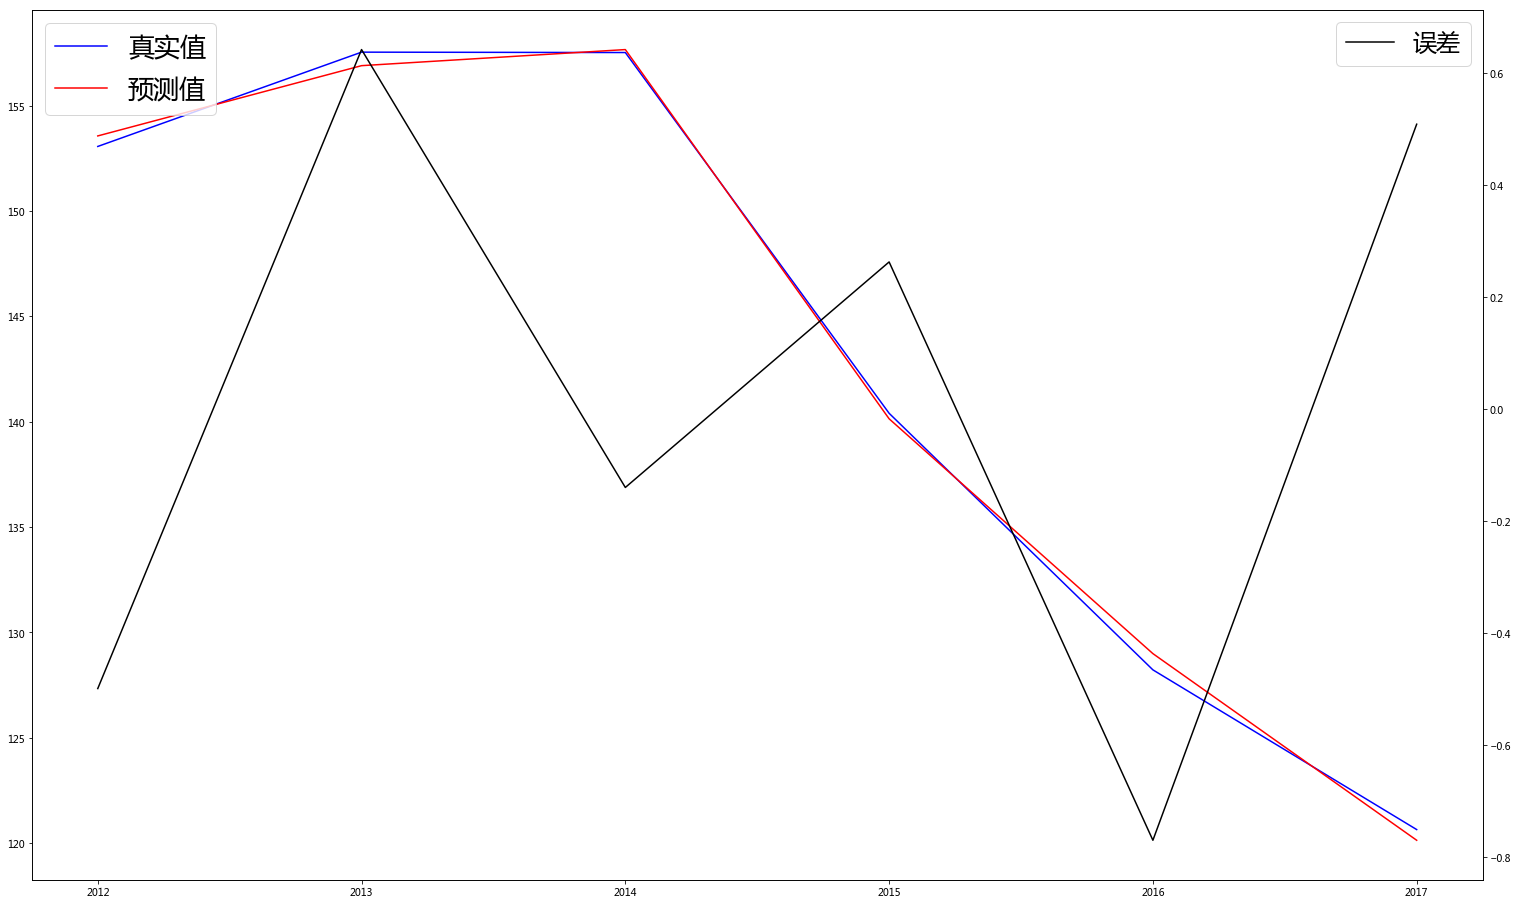

In [49]:
#plt.style.use('fivethirtyeight')
# 正常显示中文字体
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
fig,left_axis=plt.subplots(figsize = (26,16))
plot_data["actual"].plot(color ="blue")
plot_data["predictions"].plot(color ="red")
plt.legend(labels = ["真实值","预测值"], loc = 'upper left', fontsize=26)
right_axis = left_axis.twinx()
plot_data["error"].plot(color ="black")
plt.legend(labels =[ "误差"], loc = 'upper right', fontsize =24 )

#plt.title(u"标题",fontsize =36)

### 天津

In [50]:
system_tj = {'Eq100':Eq100 ,'Eq108':Eq108  ,'Eq111':Eq111,'Eq112':Eq112,'Eq113':Eq113,'Eq121':Eq121 ,'Eq131':Eq131 ,'Eq132':Eq132 ,'Eq133':Eq133,
            'Eq134':Eq134 ,'Eq135':Eq135  ,'Eq136':Eq136 ,'Eq137':Eq137  ,'Eq138':Eq138 ,'Eq145':Eq145 ,'Eq146':Eq146
            ,'Eq147':Eq147,'Eq148':Eq148,'Eq149':Eq149,'Eq150':Eq150 ,'Eq151':Eq151,'Eq153':Eq153 ,'Eq154':Eq154 ,'Eq155':Eq155
            ,'Eq156':Eq156 ,'Eq157':Eq157  ,'Eq159':Eq159,'Eq160':Eq160 ,'Eq161':Eq161 ,'Eq162':Eq162 ,'Eq165':Eq165  #,'Eq9':Eq9 
            ,'Eq166':Eq166 ,'Eq167':Eq167 ,'Eq168':Eq168 ,'Eq169':Eq169 ,'Eq170':Eq170  ,'Eq171':Eq171 ,'Eq172':Eq172 
             ,'Eq173':Eq173 ,'Eq174':Eq174 ,'Eq175':Eq175 ,'Eq176':Eq176 ,'Eq177':Eq177   ,'Eq179':Eq179 ,'Eq181':Eq181
            ,'Eq183':Eq183 ,'Eq185':Eq185 ,'Eq187':Eq187 ,'Eq189':Eq189 ,'Eq191':Eq191,'Eq192':Eq192 ,'Eq193':Eq193
             ,'Eq195':Eq195 ,'Eq196':Eq196 ,'Eq198':Eq198 ,'Eq199':Eq199 ,'Eq200':Eq200 ,'Eq201':Eq201,'Eq202':Eq202 ,'Eq203':Eq203,
            'Eq204':Eq204 , 'Eq205':Eq205, 'Eq206':Eq206, 'Eq207':Eq207, 'Eq208':Eq208 }

In [51]:
test1 = eq_disc.iloc[99:208,:]
list1 = list(test1.loc[test1["type"] != "定义方程","ID"])
print ( "联立方程个数 : ",len(system_tj) ," 独立方程个数 ： " ,len(["Eq" + str(x) for x  in [197]])
                                                    , "共有外生变量个数 ： " ,len(list1) ,"\n\n备注 ： 前两者相加等于后者，则表示正确" )

联立方程个数 :  65  独立方程个数 ：  1 共有外生变量个数 ：  66 

备注 ： 前两者相加等于后者，则表示正确


#### 联立方程求解及预测 

In [96]:
df_ev = data_ev.copy()
eqs_tj = IV3SLS.from_formula(system_tj,data= df_ev)
tj_3sls = eqs_tj.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
tj_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System OLS Estimation Summary                           
===================================================================================
Estimator:                        OLS   Overall R-squared:                   0.9999
No. Equations.:                    65   McElroy's R-squared:                       
No. Observations:                   4   Judge's (OLS) R-squared:             0.9873
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:45:28   Dhrymes's R-squared:                 0.9989
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                    Equation: Eq100, Dependent Variable: gdp1r_tj                    
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -13.351     7.9703    -1.6751     0.0939     -28.972      2.2708
cul_area_tj           0.1927     0.1314     1.4671     0.1424     -0.0648      0.4502
gdp1r_tj.shift(1)     1.0645     0.0216     49.256     0.0000      1.0221      1.1068
                    Equation: Eq108, Dependent Variable: gdp2r_tj1                    
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
gdp2r_tj1.shift(1)     0.9734     0.3660     2.6597     0.0078      0.2561      1.6907
d_gdp2r_tj_1          -333.75     237.80    -1.4035     0.1605     -799.83      132.33
gdp2_tecn_tj           0.8331     2.4282     0.3431     0.7315     -3.9261      5.5924
                                                                                      
======================================
             Instruments              
--------------------------------------
I((gdp2_tecn_tj1 + gdp2_tecn_tj2) / 2)
                                      
                   Equation: Eq111, Dependent Variable: np.log(gdp2_indar_tj)                   
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
np.log(investr_tj.shift(1))     -0.2346     0.0721    -3.2541     0.0011     -0.3760     -0.0933
np.log(exusd_tj * exrate_cn)    -0.1877     0.0311    -6.0419     0.0000     -0.2487     -0.1268
np.log(consr_tj)                 1.5721     0.1007     15.610     0.0000      1.3747      1.7695
                                                                                                
==================================
           Instruments            
----------------------------------
np.log(I(consn_tj / rpi_tj * 100))
                                  
                    Equation: Eq112, Dependent Variable: gdp2_bindar_tj                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
investr_tj                  0.0202     0.0020     10.276     0.0000      0.0163      0.0240
gdp2_bindar_tj.shift(1)     0.7048     0.0325     21.689     0.0000      0.6411      0.7685
d_gdp2_bindar_tj            23.651     1.7804     13.285     0.0000      20.162      27.141
                     Equation: Eq113, Dependent Variable: np.log(gdp3r_tj)                      
=====

In [53]:
pred_tj = pd.DataFrame(index = data_ev.index)
for k in tj_3sls.predict().keys():
    d1 = tj_3sls.predict()[k]
    pred_tj = pd.merge(pred_tj,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_tj.columns:
    pred_tj = pred_tj.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })
pred_tj.head(2)

,gdp1r_tj,gdp2r_tj1,gdp2_indar_tj,gdp2_bindar_tj,gdp3r_tj,con_gn_tj,con_pur_tj,con_prr_tj,investr_tj,inv_fir_tj,...,gdp2_mecn_tj,gdp2_emin_tj,gdp2_tran_tj,gdp3_infwn_tj,gdp2_hemin_tj,gdp2_nmin_tj,gdp2_birn_tj,gdp2_necin_tj,gdp2_nein_tj,gdp2_epin_tj
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
pred_tj.columns

Index(['gdp1r_tj', 'gdp2r_tj1', 'gdp2_indar_tj', 'gdp2_bindar_tj', 'gdp3r_tj',
       'con_gn_tj', 'con_pur_tj', 'con_prr_tj', 'investr_tj', 'inv_fir_tj',
       'nex_gsr_tj', 'consn_tj', 'exusd_tj', 'imusd_tj', 'yht_un_tj',
       'yht_rn_tj', 'cone_un_tj', 'cone_rn_tj', 'frn_tj', 'taxn_tj1',
       'taxn_tj2', 'tax_vadn_tj', 'tax_cinn_tj', 'tax_pinn_tj', 'fen_tj1',
       'fen_tj2', 'depn_tj', 'dep_san_tj', 'loan_ln_tj', 'loann_tj',
       'totemp_tj', 'emp2_tj', 'emp3_tj', 'totpop_tj', 'popu_tj', 'rpi_tj',
       'cpi_tj', 'gdp1d_tj', 'gdp2d_tj', 'gdp3d_tj', 'gdpd_tj', 'ppi_tj',
       'faipi_tj', 'gdp3_tspan_tj', 'gdp3_wran_tj', 'gdp3_fian_tj',
       'gdp3_rean_tj', 'gdp3_infn_tj', 'gdp3_renn_tj', 'gdp3_sicn_tj',
       'gdp2_tecn_tj1', 'gdp2_tecn_tj2', 'gdp2_medn_tj', 'tta_tj',
       'gdp2_caln_tj', 'gdp2_mecn_tj', 'gdp2_emin_tj', 'gdp2_tran_tj',
       'gdp3_infwn_tj', 'gdp2_hemin_tj', 'gdp2_nmin_tj', 'gdp2_birn_tj',
       'gdp2_necin_tj', 'gdp2_nein_tj', 'gdp2_epin_tj'],
    

#### 求定义方程

In [55]:
def def_tj(Eqid) : #求解北京定义方程
    global exogs
    global test_data
    global preds
    global Eqs
                
    if Eqid =="Eq101": 
        y = "gdpn_tj"
        x_list = ["gdp1n_tj","gdp2n_tj","gdp3n_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = test_data[["gdpn_tj","gdp1n_tj","gdp2n_tj","gdp3n_tj"]]
            test1[y] = test1["gdp1n_tj"] + test1["gdp2n_tj"] + test1["gdp3n_tj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq102": 
        y = "gdpr_tj"
        x_list = ["gdp1r_tj","gdp2r_tj","gdp3r_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = test_data[["gdpr_tj","gdp1r_tj","gdp2r_tj","gdp3r_tj"]]
            test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1[y] = test1["gdp1r_tj"] + test1["gdp2r_tj"] + test1["gdp3r_tj"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
            
    if Eqid =="Eq103": 
        y = "gdp1n_tj"
        x_list = ["gdp1r_tj","gdp1d_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["gdp1n_tj","gdp1r_tj","gdp1d_tj"]]
            test1[y] = test1["gdp1r_tj"]*test1["gdp1d_tj"]/100

            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
        
    if Eqid =="Eq104": 
        y = "gdp2_indan_tj"
        x_list = ["gdp2_indar_tj","gdp2_indad_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["gdp2_indan_tj","gdp2_indar_tj","gdp2_indad_tj"]]
            test1[y] = test1["gdp2_indar_tj"]*test1["gdp2_indad_tj"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq105": 
        y = "gdp2_bindan_tj"
        x_list = ["gdp2_bindar_tj","gdp2_bindad_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["gdp2_bindan_tj","gdp2_bindar_tj","gdp2_bindad_tj"]]
            test1[y] = test1["gdp2_bindar_tj"]*test1["gdp2_bindad_tj"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq106": 
        y = "gdp2n_tj"
        x_list = ["gdp2r_tj","gdp2d_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp2n_tj","gdp2r_tj","gdp2d_tj"]]
            test1[y] = test1["gdp2r_tj"]*test1["gdp2d_tj"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq107":
        y = "gdp2r_tj2"
        x_list = ["gdp2_indar_tj","gdp2_bindar_tj","gdp2r_erro_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp2r_tj2","gdp2_indar_tj","gdp2_bindar_tj","gdp2r_erro_tj"]]
            test1[y] = test1["gdp2_indar_tj"] + test1["gdp2_bindar_tj"] + test1["gdp2r_erro_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq109": 
        y = "gdp2r_tj"
        x_list = ["gdp2r_tj1","gdp2r_tj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["gdp2r_tj","gdp2r_tj1","gdp2r_tj2"]]
            test1[y] = (test1["gdp2r_tj1"] + test1["gdp2r_tj2"])/2                        
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq110": 
        y = "gdp3n_tj"
        x_list = ["gdp3r_tj","gdp3d_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["gdp3n_tj","gdp3r_tj","gdp3d_tj"]]
            test1[y] = (test1["gdp3r_tj"] * test1["gdp3d_tj"])/100            
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq114": 
        y = "con_fr_tj"
        x_list = ["con_pr_tj" , "con_gr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):    
            test1 = test_data[["con_fr_tj" ,"con_pr_tj" , "con_gr_tj"]]
            test1[y] = (test1["con_pr_tj"] + test1["con_gr_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
        
    if Eqid =="Eq115": 
        y = "con_gr_tj"
        x_list = ["con_gn_tj" , "pcon_gd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["con_gr_tj" ,"con_gn_tj" , "pcon_gd_tj"]]
            test1[y] = (test1["con_gn_tj"] /test1["pcon_gd_tj"])*100                        
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq116": 
        y = "con_pr_tj"
        x_list = ["con_pur_tj" , "con_prr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["con_pr_tj" ,"con_pur_tj" , "con_prr_tj"]]
            test1[y] = (test1["con_pur_tj"] + test1["con_prr_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq117": 
        y = "con_fn_tj"
        x_list = ["con_pn_tj" , "con_gn_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["con_fn_tj" ,"con_pn_tj" , "con_gn_tj"]]
            test1[y] = (test1["con_pn_tj"] + test1["con_gn_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
        
    if Eqid =="Eq118": 
        y = "con_pn_tj"
        x_list = ["con_pun_tj" , "con_prn_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["con_pn_tj" ,"con_pun_tj" , "con_prn_tj"]]
            test1[y] = (test1["con_pun_tj"] + test1["con_prn_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq119": 
        y = "con_pun_tj"
        x_list = ["con_pur_tj","pcon_pud_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["con_pun_tj" ,"con_pur_tj","pcon_pud_tj"]]
            test1[y] = (test1["con_pur_tj"] * test1["pcon_pud_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq120": 
        y = "con_prn_tj"
        x_list = ["con_prr_tj" , "pcon_prd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["con_prn_tj" ,"con_prr_tj" , "pcon_prd_tj"]]
            test1[y] = (test1["con_prr_tj"] * test1["pcon_prd_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq122": 
        y = "investn_tj"
        x_list = ["investr_tj" , "faipi_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):    
            test1 = test_data[["investn_tj" ,"investr_tj" , "faipi_tj"]]
            test1[y] = (test1["investr_tj"] * test1["faipi_tj"]) /100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
        
    if Eqid =="Eq123": 
        y = "inv_fon_tj"
        x_list = ["inv_for_tj" , "pinv_fod_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = test_data[["inv_fon_tj" ,"inv_for_tj" , "pinv_fod_tj"]]
            test1[y] = (test1["inv_for_tj"] * test1["pinv_fod_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq124": 
        
        y = "inv_chn_tj"
        x_list = ["inv_chr_tj" , "pinv_chd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = test_data[["inv_chn_tj" ,"inv_chr_tj" , "pinv_chd_tj"]]
            test1[y] = (test1["inv_chr_tj"] * test1["pinv_chd_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
            
    if Eqid =="Eq125": 
        y = "consr_tj"
        x_list = ["consn_tj" , "rpi_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["consr_tj" ,"consn_tj" , "rpi_tj"]]
            test1[y] = (test1["consn_tj"] / test1["rpi_tj"])*100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq126": 
        y = "inv_for_tj"
        x_list = ["inv_fir_tj" , "inv_chr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["inv_for_tj" ,"inv_fir_tj" , "inv_chr_tj"]]
            test1[y] = test1["inv_fir_tj"] + test1["inv_chr_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq127": 
        y = "inv_fin_tj"
        x_list = ["inv_fir_tj" , "pinv_fid_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["inv_fin_tj" ,"inv_fir_tj" , "pinv_fid_tj"]]
            test1[y] = (test1["inv_fir_tj"] * test1["pinv_fid_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq128": 
        y = "gdper_tj"
        x_list = ["con_fr_tj","inv_for_tj","nex_gsr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["gdper_tj" ,"con_fr_tj","inv_for_tj","nex_gsr_tj"]]
            test1[y] = test1["con_fr_tj"] + test1["inv_for_tj"] + test1["nex_gsr_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
        
    if Eqid =="Eq129": 
        y = "gdpen_tj"
        x_list = ["con_fn_tj" , "inv_fon_tj","nex_gsn_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["gdpen_tj" ,"con_fn_tj" , "inv_fon_tj","nex_gsn_tj"]]
            test1[y] = test1["con_fn_tj"] + test1["inv_fon_tj"] + test1["nex_gsn_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
            
        
    if Eqid =="Eq130": 
        y = "nex_gsn_tj"
        x_list = ["nex_gsr_tj" , "pnex_gsd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["nex_gsn_tj" ,"nex_gsr_tj" , "pnex_gsd_tj"]]
            test1[y] = (test1["nex_gsr_tj"] * test1["pnex_gsd_tj"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq139": 
        y = "yht_n_tj"
        x_list = ["yht_rn_tj","yht_un_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):     
            test1 = test_data[["yht_n_tj" ,"yht_rn_tj","yht_un_tj"]]
            test1[y] = test1["yht_rn_tj"] + test1["yht_un_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq140": 
        y = "yh_un_tj"
        x_list = ["yht_un_tj","popu_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["yh_un_tj" ,"yht_un_tj","popu_tj"]]
            test1[y] = (test1["yht_un_tj"] / test1["popu_tj"])            
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
        
    if Eqid =="Eq141": 
        y = "yh_rn_tj"
        x_list = ["yht_rn_tj","popr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["yh_rn_tj" ,"yht_rn_tj","popr_tj"]]
            test1[y] = (test1["yht_rn_tj"] / test1["popr_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq142": 
        y = "yhn_tj"
        x_list = ["yht_n_tj","totpop_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["yhn_tj" ,"yht_n_tj","totpop_tj"]]
            test1[y] = (test1["yht_n_tj"] / test1["totpop_tj"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq143": 
        y = "conet_un_tj"
        x_list = ["cone_un_tj","popu_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):     
            test1 = test_data[["conet_un_tj" ,"cone_un_tj","popu_tj"]]
            test1[y] = test1["cone_un_tj"] * test1["popu_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq144": 
        y = "conet_rn_tj"
        x_list = ["cone_rn_tj","popr_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["conet_rn_tj" ,"cone_rn_tj","popr_tj"]]
            test1[y] = test1["cone_rn_tj"] * test1["popr_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq152": 
        y = "taxn_tj"
        x_list = ["taxn_tj1","taxn_tj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):     
            test1 = test_data[["taxn_tj","taxn_tj1","taxn_tj2"]]
            test1[y] = (test1["taxn_tj1"] + test1["taxn_tj2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq158": 
        y = "fen_tj"
        x_list = ["fen_tj1","fen_tj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0): 
            test1 = test_data[["fen_tj","fen_tj1","fen_tj2"]]
            test1[y] = (test1["fen_tj1"]+test1["fen_tj2"])/2                        
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
            
        
    if Eqid =="Eq163": 
        y = "emp1_tj"
        x_list = ["totemp_tj" , "emp2_tj" , "emp3_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):    
            test1 = test_data[["emp1_tj" , "totemp_tj" , "emp2_tj" , "emp3_tj"]]
            test1[y] = test1["totemp_tj"] - test1["emp2_tj"] - test1["emp3_tj"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq164": 
        y = "popr_tj"
        x_list = ["totpop_tj" , "popu_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["popr_tj" , "totpop_tj" , "popu_tj" ]]
            test1[y] = test1["totpop_tj"] - test1["popu_tj"]             
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq178": 
        y = "gdp3_tspar_tj"
        x_list = ["gdp3_tspan_tj","pgdp3_tspad_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):              
            test1 = test_data[["gdp3_tspar_tj","gdp3_tspan_tj","pgdp3_tspad_tj"]]
            test1[y] = test1["gdp3_tspan_tj"] / test1["pgdp3_tspad_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq180": 
        y = "gdp3_wrar_tj"
        x_list = ["gdp3_wran_tj","pgdp3_wrad_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp3_wrar_tj","gdp3_wran_tj","pgdp3_wrad_tj"]]
            test1[y] = test1["gdp3_wran_tj"] / test1["pgdp3_wrad_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
            
        
    if Eqid =="Eq182": 
        y = "gdp3_fiar_tj"
        x_list = ["gdp3_fian_tj","pgdp3_fiad_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):    
            test1 = test_data[["gdp3_fiar_tj","gdp3_fian_tj","pgdp3_fiad_tj"]]
            test1[y] = test1["gdp3_fian_tj"] / test1["pgdp3_fiad_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq184": 
        y = "gdp3_rear_tj"
        x_list = ["gdp3_rean_tj","pgdp3_read_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp3_rear_tj","gdp3_rean_tj","pgdp3_read_tj"]]
            test1[y] = test1["gdp3_rean_tj"] / test1["pgdp3_read_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq186": 
        y = "gdp3_infr_tj"
        x_list = ["gdp3_infn_tj","pgdp3_infd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):   
            test1 = test_data[["gdp3_infr_tj","gdp3_infn_tj","pgdp3_infd_tj"]]
            test1[y] = test1["gdp3_infn_tj"] / test1["pgdp3_infd_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq188": 
        y = "gdp3_renr_tj"
        x_list = ["gdp3_renn_tj","pgdp3_rend_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp3_renr_tj","gdp3_renn_tj","pgdp3_rend_tj"]]
            test1[y] = test1["gdp3_renn_tj"] / test1["pgdp3_rend_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq190": 
        y = "gdp3_sicr_tj"
        x_list = ["gdp3_sicn_tj","pgdp3_sicd_tj"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp3_sicr_tj","gdp3_sicn_tj","pgdp3_sicd_tj"]]
            test1[y] = test1["gdp3_sicn_tj"] / test1["pgdp3_sicd_tj"] *100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )              
            
        
    if Eqid =="Eq194":  
        
        y = "gdp2_tecn_tj"
        x_list = ["gdp2_tecn_tj1","gdp2_tecn_tj2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):  
            test1 = test_data[["gdp2_tecn_tj","gdp2_tecn_tj1","gdp2_tecn_tj2"]]
            test1[y] = (test1["gdp2_tecn_tj1"] + test1["gdp2_tecn_tj2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )          
            
    return  exogs , test_data ,preds,Eqs            

In [56]:
# 测试 ：贴换数据源
test_data = df_ev.copy()
for col1 in pred_tj.columns :
    test_data[col1] = pred_tj[col1] ##联立方程的结果替换掉原数据

In [57]:
#测试
Eqs = Eqlist.copy() #可以再缩小到定义方程列表
exogs =[ x for x in exogs_tj if x not in list(pred_tj.columns)]# 列表
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
for eqid in Eqs[99:208] :
    exogs,test_data,preds,Eqs = def_tj(eqid)    
del exogs,test_data,preds

Eq101 gdpn_tj 还不能求解 ，因还未获得外生变量:   ['gdp1n_tj', 'gdp2n_tj', 'gdp3n_tj']
Eq102 gdpr_tj 还不能求解 ，因还未获得外生变量:   ['gdp2r_tj']
Eq103 gdp1n_tj ----------------   求解成功 。
Eq104 gdp2_indan_tj ----------------   求解成功 。
Eq105 gdp2_bindan_tj ----------------   求解成功 。
Eq106 gdp2n_tj 还不能求解 ，因还未获得外生变量:   ['gdp2r_tj']
Eq107 gdp2r_tj2 ----------------   求解成功 。
Eq109 gdp2r_tj ----------------   求解成功 。
Eq110 gdp3n_tj ----------------   求解成功 。
Eq114 con_fr_tj 还不能求解 ，因还未获得外生变量:   ['con_pr_tj', 'con_gr_tj']
Eq115 con_gr_tj ----------------   求解成功 。
Eq116 con_pr_tj ----------------   求解成功 。
Eq117 con_fn_tj 还不能求解 ，因还未获得外生变量:   ['con_pn_tj']
Eq118 con_pn_tj 还不能求解 ，因还未获得外生变量:   ['con_pun_tj', 'con_prn_tj']
Eq119 con_pun_tj ----------------   求解成功 。
Eq120 con_prn_tj ----------------   求解成功 。
Eq122 investn_tj ----------------   求解成功 。
Eq123 inv_fon_tj 还不能求解 ，因还未获得外生变量:   ['inv_for_tj']
Eq124 inv_chn_tj ----------------   求解成功 。
Eq125 consr_tj ----------------   求解成功 。
Eq126 inv_for_tj ----------------   求解成功 。
Eq127 

In [58]:
#正式 -- 求解
test_data = df_ev.copy()
for col1 in pred_tj.columns :
    test_data[col1] = pred_tj[col1]

Eqs = Eqlist[99:208].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_tj if x not in list(pred_tj.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_tj(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break     
#del exogs,df_ev,preds,Eqs

-----------fold n ---- 1  -------------------
Eq101 gdpn_tj 还不能求解 ，因还未获得外生变量:   ['gdp1n_tj', 'gdp2n_tj', 'gdp3n_tj']
Eq102 gdpr_tj 还不能求解 ，因还未获得外生变量:   ['gdp2r_tj']
Eq103 gdp1n_tj ----------------   求解成功 。
Eq105 gdp2_bindan_tj ----------------   求解成功 。
Eq107 gdp2r_tj2 ----------------   求解成功 。
Eq109 gdp2r_tj ----------------   求解成功 。
Eq114 con_fr_tj 还不能求解 ，因还未获得外生变量:   ['con_pr_tj', 'con_gr_tj']
Eq115 con_gr_tj ----------------   求解成功 。
Eq117 con_fn_tj 还不能求解 ，因还未获得外生变量:   ['con_pn_tj']
Eq118 con_pn_tj 还不能求解 ，因还未获得外生变量:   ['con_pun_tj', 'con_prn_tj']
Eq119 con_pun_tj ----------------   求解成功 。
Eq122 investn_tj ----------------   求解成功 。
Eq124 inv_chn_tj ----------------   求解成功 。
Eq126 inv_for_tj ----------------   求解成功 。
Eq128 gdper_tj 还不能求解 ，因还未获得外生变量:   ['con_fr_tj']
Eq129 gdpen_tj 还不能求解 ，因还未获得外生变量:   ['con_fn_tj', 'inv_fon_tj', 'nex_gsn_tj']
Eq130 nex_gsn_tj ----------------   求解成功 。
Eq139 yht_n_tj ----------------   求解成功 。
Eq141 yh_rn_tj 还不能求解 ，因还未获得外生变量:   ['popr_tj']
Eq142 yhn_tj ---

In [59]:
print ("共有定义方程 ：",sum(eq_disc.iloc[99:208,1]=="定义方程"),"已求解的定义方程个数 ： ", preds.shape[1] ,"两者相等才能完整 。\n如果不完整，查看exogs ")
# 如果查看：exogs

共有定义方程 ： 43 已求解的定义方程个数 ：  43 两者相等才能完整 。
如果不完整，查看exogs 


In [60]:
exogs # 这是独立方程，下一步进行计算

['gdp2_airn_tj']

In [61]:
# 合并结果
pred_tj = pd.merge(pred_tj,preds ,how ="left" ,left_index =True ,right_index =True)
pred_tj.shape # 等于总等式个数表示，成功

(25, 108)

#### 独立方程求解及预测 
- 数据比较好的，尽量放到联立方程中



In [62]:
# EQ 197 gdp2_tecn_tj ，"gdp2_tecn_tj1","gdp2_tecn_tj2"内生变量 ==》在预测数据中获取最新 
test1 = pd.merge(df_ev[["gdp2_airn_tj","d_gdp2_airn_tj"]],pred_tj[["gdp2_tecn_tj","gdp2_tecn_tj1","gdp2_tecn_tj2"]],how ="left",right_index =True ,left_index =True)
test1["gdp2_tecn_tj_diff"] = test1["gdp2_tecn_tj"] - test1["gdp2_tecn_tj"].shift(1)
test1 = test1[(test1.index>2014) & (test1.index <2018)]
results = sm.ols(formula = " gdp2_airn_tj ~ gdp2_tecn_tj_diff + d_gdp2_airn_tj",data = test1 ).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gdp2_airn_tj   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 23 Jul 2020   Prob (F-statistic):                nan
Time:                        01:11:10   Log-Likelihood:                 85.674
No. Observations:                   3   AIC:                            -165.3
Df Residuals:                       0   BIC:                            -168.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            56.3033        inf          0        nan         nan         nan
gdp2_tecn_tj_diff     0.3622        inf          0        nan         nan         nan
d_gdp2_airn_tj       88.5146        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.207
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.503
Skew:                          -0.665   Prob(JB):                        0.778
Kurtosis:                       1.500   Cond. No.                         488.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
test1

,gdp2_airn_tj,d_gdp2_airn_tj,gdp2_tecn_tj,gdp2_tecn_tj1,gdp2_tecn_tj2,gdp2_tecn_tj_diff
2015,161.070540,0.0,1110.467658,1208.565518,1012.369799,289.286309
2016,195.820824,1.0,1251.298432,1258.683227,1243.913636,140.830773
2017,24.649684,-0.8,1359.422780,1303.573000,1415.272561,108.124349


In [64]:
y = "gdp2_airn_tj"
test1[y] = results.predict()
pred_tj= pd.merge(pred_tj,test1[[y]],how = "left",left_index =True ,right_index = True)
pred_tj.shape

(25, 109)

### 河北


In [65]:
system_hb = {'Eq209':Eq209, 'Eq217':Eq217 ,'Eq220':Eq220 ,  'Eq221':Eq221, 'Eq222':Eq222, 'Eq227':Eq227 , 'Eq228':Eq228
            , 'Eq229':Eq229, 'Eq230':Eq230, 'Eq231':Eq231, 'Eq238':Eq238 , 'Eq239':Eq239 , 'Eq240':Eq240  , 'Eq241':Eq241
            , 'Eq242':Eq242 , 'Eq243':Eq243 , 'Eq244':Eq244, 'Eq246':Eq246 , 'Eq247':Eq247 , 'Eq248':Eq248 
            , 'Eq249':Eq249 , 'Eq250':Eq250 , 'Eq252':Eq252, 'Eq253':Eq253, 'Eq254':Eq254, 'Eq255':Eq255 , 'Eq258':Eq258
            , 'Eq259':Eq259 , 'Eq260':Eq260, 'Eq261':Eq261, 'Eq262':Eq262, 'Eq263':Eq263, 'Eq264':Eq264, 'Eq265':Eq265
             , 'Eq266':Eq266 , 'Eq267':Eq267, 'Eq268':Eq268 , 'Eq269':Eq269, 'Eq270':Eq270 , 'Eq271':Eq271, 'Eq272':Eq272
            , 'Eq273':Eq273, 'Eq274':Eq274 , 'Eq275':Eq275 , 'Eq276':Eq276 , 'Eq277':Eq277,  'Eq278':Eq278,'Eq279':Eq279, 
             'Eq281':Eq281 ,  'Eq283':Eq283} #,  'Eq278':Eq278, 'Eq279':Eq279 ,  'Eq281':Eq281, 'Eq283':Eq283

In [66]:
test1 = eq_disc.iloc[208:284,:]
list1 = list(test1.loc[test1["type"] != "定义方程","ID"])
print ( "联立方程个数 : ",len(system_hb) ," 独立方程个数 ： " ,len(["Eq" + str(x) for x  in []])
                                                    , "共有外生变量个数 ： " ,len(list1) )

联立方程个数 :  50  独立方程个数 ：  0 共有外生变量个数 ：  50


#### 联立方程求解及预测

In [67]:
df_ev = data_ev.copy()
eqs_hb = IV3SLS.from_formula(system_hb,data= df_ev)
hb_3sls = eqs_hb.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
hb_3sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                           System OLS Estimation Summary                           
===================================================================================
Estimator:                        OLS   Overall R-squared:                   0.9996
No. Equations.:                    50   McElroy's R-squared:                       
No. Observations:                   4   Judge's (OLS) R-squared:             0.9914
Date:                Thu, Jul 23 2020   Berndt's R-squared:                        
Time:                        01:11:12   Dhrymes's R-squared:                 0.9916
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                    Equation: Eq209, Dependent Variable: gdp1r_hb                    
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -253.96     250.05    -1.0156     0.3098     -744.05      236.13
gdp1r_hb.shift(1)     1.1085     0.0735     15.083     0.0000      0.9645      1.2526
                                      Equation: Eq217, Dependent Variable: gdp2r_hb1                                     
=========================================================================================================================
                                                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -8509.8     871.87    -9.7604     0.0000  -1.022e+04     -6800.9
gdp2_tecn_sum(gdp2_tecn_hb1, gdp2_tecn_hb2, gdp2d_hb)    -210.47     22.164    -9.4963     0.0000     -253.91     -167.03
gdp2r_hb1.shift(1)                                        1.9393     0.0917     21.154     0.0000      1.7596      2.1190
                       Equation: Eq220, Dependent Variable: gdp2_indar_hb                       
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
np.log(investr_hb)              -802.44     502.27    -1.5976     0.1101     -1786.9      181.98
np.log(exusd_hb * exrate_cn)    -2966.5     167.79    -17.680     0.0000     -3295.3     -2637.6
np.log(consr_hb)                 6060.8     467.13     12.975     0.0000      5145.2      6976.3
                                                                                                
===============================
          Instruments          
-------------------------------
np.log(consn_hb / rpi_hb * 100)
                               
             Equation: Eq221, Dependent Variable: np.log(gdp2_bindar_hb)              
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -1.5160     1.8531    -0.8181     0.4133     -5.1480      2.1160
np.log(investr_hb)     0.8767     0.1799     4.8719     0.0000      0.5240      1.2294
                     Equation: Eq222, Dependent Variable: gdp3r_hb                      
========================================================================================
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
Interc

In [68]:
hb_3sls.predict().keys()

dict_keys(['Eq209', 'Eq217', 'Eq220', 'Eq221', 'Eq222', 'Eq227', 'Eq228', 'Eq229', 'Eq230', 'Eq231', 'Eq238', 'Eq239', 'Eq240', 'Eq241', 'Eq242', 'Eq243', 'Eq244', 'Eq246', 'Eq247', 'Eq248', 'Eq249', 'Eq250', 'Eq252', 'Eq253', 'Eq254', 'Eq255', 'Eq258', 'Eq259', 'Eq260', 'Eq261', 'Eq262', 'Eq263', 'Eq264', 'Eq265', 'Eq266', 'Eq267', 'Eq268', 'Eq269', 'Eq270', 'Eq271', 'Eq272', 'Eq273', 'Eq274', 'Eq275', 'Eq276', 'Eq277', 'Eq278', 'Eq279', 'Eq281', 'Eq283'])

In [69]:
pred_hb = pd.DataFrame(index = data_ev.index)
for k in hb_3sls.predict().keys():
    d1 = hb_3sls.predict()[k]
    pred_hb = pd.merge(pred_hb,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_hb.columns:
    pred_hb = pred_hb.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })
pred_hb.columns

Index(['gdp1r_hb', 'gdp2r_hb1', 'gdp2_indar_hb', 'gdp2_bindar_hb', 'gdp3r_hb',
       'con_fn_hb', 'investr_hb', 'consn_hb', 'exusd_hb', 'imusd_hb',
       'yht_un_hb', 'yht_rn_hb', 'cone_un_hb', 'cone_rn_hb', 'frn_hb',
       'taxn_hb1', 'taxn_hb2', 'tax_vadn_hb', 'tax_cinn_hb', 'tax_pinn_hb',
       'fen_hb1', 'fen_hb2', 'depn_hb', 'dep_san_hb', 'loan_ln_hb', 'loann_hb',
       'totemp_hb', 'emp2_hb', 'emp3_hb', 'totpop_hb', 'popu_hb', 'rpi_hb',
       'cpi_hb', 'gdp1d_hb', 'gdp2d_hb', 'gdp3d_hb', 'gdpd_hb', 'ppi_hb',
       'faipi_hb', 'gdp3_tspan_hb', 'gdp3_wran_hb', 'gdp3_fian_hb',
       'gdp3_rean_hb', 'gdp3_infn_hb', 'gdp3_renn_hb', 'gdp3_sicn_hb',
       'gdp2_tecn_hb1', 'gdp2_tecn_hb2', 'tta_hb', 'gdp2_emin_hb'],
      dtype='object')

#### 求定义方程

In [70]:
def def_hb(Eqid) : #求解北京定义方程
    global exogs
    global test_data
    global preds
    global Eqs
                
    if Eqid =="Eq210": 
        y = "gdpn_hb"
        x_list = ["gdp1n_hb","gdp2n_hb","gdp3n_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = df_ev[["gdpn_hb","gdp1n_hb","gdp2n_hb","gdp3n_hb"]]
            test1["预测"] = test1["gdp1n_hb"] + test1["gdp2n_hb"] + test1["gdp3n_hb"]
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
            
    if Eqid =="Eq211": 
        y = "gdpr_hb"
        x_list = ["gdp1r_hb","gdp2r_hb","gdp3r_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):

            test1 = df_ev[["gdpr_hb","gdp1r_hb","gdp2r_hb","gdp3r_hb"]]
            test1 = test1[(test1.index>1996) & (test1.index <2018)]
            test1["预测"] = test1["gdp1r_hb"] + test1["gdp2r_hb"] + test1["gdp3r_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                        
    if Eqid =="Eq212": 
        y = "gdp1n_hb"
        x_list = ["gdp1r_hb","gdp1d_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp1n_hb","gdp1r_hb","gdp1d_hb"]]
            test1["验证结果"] = test1["gdp1r_hb"]*test1["gdp1d_hb"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq213": 
        y = "gdp2_indan_hb"
        x_list = ["gdp2_indar_hb","gdp2_indad_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp2_indan_hb","gdp2_indar_hb","gdp2_indad_hb"]]
            test1["验证结果"] = test1["gdp2_indar_hb"]*test1["gdp2_indad_hb"]/100
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq214": 
        y = "gdp2_bindan_hb"
        x_list = ["gdp2_bindar_hb","gdp2_bindad_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp2_bindan_hb","gdp2_bindar_hb","gdp2_bindad_hb"]]
            test1["预测"] = test1["gdp2_bindar_hb"]*test1["gdp2_bindad_hb"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq215": 
        y = "gdp2n_hb"
        x_list = ["gdp2r_hb","gdp2d_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp2n_hb","gdp2r_hb","gdp2d_hb"]]
            test1["预测"] = test1["gdp2r_hb"]*test1["gdp2d_hb"]/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq216":
        y = "gdp2r_hb2"
        x_list = ["gdp2_indar_hb","gdp2_bindar_hb","gdp2r_erro_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp2r_hb2","gdp2_indar_hb","gdp2_bindar_hb","gdp2r_erro_hb"]]
            test1["预测"] = test1["gdp2_indar_hb"] + test1["gdp2_bindar_hb"] + test1["gdp2r_erro_hb"]
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq218": 
        y = "gdp2r_hb"
        x_list = ["gdp2r_hb1","gdp2r_hb2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdp2r_hb","gdp2r_hb1","gdp2r_hb2"]]
            test1["预测"] = (test1["gdp2r_hb1"] + test1["gdp2r_hb2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq219": 
        y = "gdp3n_hb"
        x_list = ["gdp3r_hb","gdp3d_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["gdp3n_hb","gdp3r_hb","gdp3d_hb"]]
            test1["预测"] = (test1["gdp3r_hb"] * test1["gdp3d_hb"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq223": 
        y = "investn_hb"
        x_list = ["investr_hb" , "faipi_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["investn_hb" ,"investr_hb" , "faipi_hb"]]
            test1["验证结果"] = (test1["investr_hb"] * test1["faipi_hb"]) /100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq224": 
        y = "consr_hb"
        x_list = ["consn_hb" , "rpi_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["consr_hb" ,"consn_hb" , "rpi_hb"]]
            test1["预测"] = (test1["consn_hb"] /test1["rpi_hb"])*100
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq225": 
        y = "gdper_hb"
        x_list = ["gdpen_hb" , "gdpd_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdper_hb" ,"gdpen_hb" , "gdpd_hb"]]
            test1["预测"] = (test1["gdpen_hb"] * test1["gdpd_hb"])/100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] )             
                    
    if Eqid =="Eq226": 
        y = "gdpen_hb"
        x_list = ["con_fn_hb" ,"inv_fon_hb" , "nex_gsn_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["gdpen_hb","con_fn_hb" ,"inv_fon_hb" , "nex_gsn_hb"]]
            test1["预测"] = test1["con_fn_hb"] + test1["inv_fon_hb"] + test1["nex_gsn_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq232": 
        y = "yht_n_hb"
        x_list = ["yht_rn_hb","yht_un_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["yht_n_hb" ,"yht_rn_hb","yht_un_hb"]]
            test1["预测"] = test1["yht_rn_hb"] + test1["yht_un_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
    if Eqid =="Eq233": 
        y = "yh_un_hb"
        x_list = ["yht_un_hb","popu_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["yh_un_hb" ,"yht_un_hb","popu_hb"]]
            test1["预测"] = (test1["yht_un_hb"] / test1["popu_hb"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq234": 
        y = "yh_rn_hb"
        x_list = ["yht_rn_hb","popr_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["yh_rn_hb" ,"yht_rn_hb","popr_hb"]]
            test1["预测"] = (test1["yht_rn_hb"] / test1["popr_hb"])            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq235": 
        y = "yhn_hb"
        x_list = ["yht_n_hb","totpop_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["yhn_hb" ,"yht_n_hb","totpop_hb"]]
            test1["预测"] = (test1["yht_n_hb"] / test1["totpop_hb"])
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
    if Eqid =="Eq236": 
        y = "conet_un_hb"
        x_list = ["cone_un_hb","popu_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["conet_un_hb" ,"cone_un_hb","popu_hb"]]
            test1["预测"] = test1["cone_un_hb"] * test1["popu_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
            
                    
    if Eqid =="Eq237": 
        y = "conet_rn_hb"
        x_list = ["cone_rn_hb","popr_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["conet_rn_hb" ,"cone_rn_hb","popr_hb"]]
            test1["预测"] = test1["cone_rn_hb"] * test1["popr_hb"]
            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq245": 
        y = "taxn_hb"
        x_list = ["taxn_hb1","taxn_hb2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        
            test1 = df_ev[["taxn_hb","taxn_hb1","taxn_hb2"]]
            test1["预测"] = (test1["taxn_hb1"] + test1["taxn_hb2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq251": 
        y = "fen_hb"
        x_list = ["fen_hb1","fen_hb2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["fen_hb","fen_hb1","fen_hb2"]]
            test1["预测"] = (test1["fen_hb1"] + test1["fen_hb2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq256": 
        y = "emp1_hb"
        x_list = ["totemp_hb" , "emp2_hb" , "emp3_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["emp1_hb" , "totemp_hb" , "emp2_hb" , "emp3_hb"]]
            test1["预测"] = test1["totemp_hb"] - test1["emp2_hb"] - test1["emp3_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq257": 
        y = "popr_hb"
        x_list = ["totpop_hb" , "popu_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["popr_hb" , "totpop_hb" , "popu_hb" ]]
            test1["预测"] = test1["totpop_hb"] - test1["popu_hb"]            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq280": 
        y = "gdp2_tecn_hb"
        x_list = ["gdp2_tecn_hb1","gdp2_tecn_hb2"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["gdp2_tecn_hb","gdp2_tecn_hb1","gdp2_tecn_hb2"]]
            test1["预测"] = (test1["gdp2_tecn_hb1"] + test1["gdp2_tecn_hb2"])/2            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    
    if Eqid =="Eq282": 
        
        y = "gdp2_tecr_hb"
        x_list = ["gdp2_tecn_hb","pgdp2_tecd_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):
            test1 = df_ev[["gdp2_tecr_hb","gdp2_tecn_hb","pgdp2_tecd_hb"]]
            test1["验证结果"] = test1["gdp2_tecn_hb"]/test1["pgdp2_tecd_hb"]*100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                        
    if Eqid =="Eq284": 
        y = "gdp2_emir_hb"
        x_list = ["gdp2_emin_hb","pgdp2_emin_hb"]
        if (y in exogs) & (len([x for x in x_list if x in exogs])==0):        

            test1 = df_ev[["gdp2_emir_hb","gdp2_emin_hb","pgdp2_emin_hb"]]
            test1["预测"] = (test1["gdp2_emin_hb"] /test1["pgdp2_emin_hb"])*100            
            preds = pd.merge(preds,test1[[y]],how = "left",left_index =True ,right_index = True)
            test_data[y] = preds[y]
            exogs.remove(y)
            Eqs.remove(Eqid)
            print(Eqid ,y,"----------------   求解成功 。")
        else:
            print(Eqid ,y, "还不能求解 ，因还未获得外生变量:  ",[x for x in x_list if x in exogs] ) 
            
                    

    return  exogs , df_ev ,preds,Eqs            

In [71]:
# 测试 ：贴换数据源
test_data = df_ev.copy()
for col1 in pred_hb.columns :
    test_data[col1] = pred_hb[col1] ##联立方程的结果替换掉原数据

In [72]:
#测试
Eqs = Eqlist.copy() #可以再缩小到定义方程列表
exogs =[ x for x in exogs_hb if x not in list(pred_hb.columns)]# 列表
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
for eqid in Eqs[208:284] :
    exogs,test_data,preds,Eqs = def_hb(eqid)    
del exogs,test_data,preds

Eq210 gdpn_hb 还不能求解 ，因还未获得外生变量:   ['gdp1n_hb', 'gdp2n_hb', 'gdp3n_hb']
Eq211 gdpr_hb 还不能求解 ，因还未获得外生变量:   ['gdp2r_hb']
Eq212 gdp1n_hb ----------------   求解成功 。
Eq213 gdp2_indan_hb ----------------   求解成功 。
Eq214 gdp2_bindan_hb ----------------   求解成功 。
Eq215 gdp2n_hb 还不能求解 ，因还未获得外生变量:   ['gdp2r_hb']
Eq216 gdp2r_hb2 ----------------   求解成功 。
Eq218 gdp2r_hb ----------------   求解成功 。
Eq219 gdp3n_hb ----------------   求解成功 。
Eq223 investn_hb ----------------   求解成功 。
Eq224 consr_hb ----------------   求解成功 。
Eq225 gdper_hb 还不能求解 ，因还未获得外生变量:   ['gdpen_hb']
Eq226 gdpen_hb ----------------   求解成功 。
Eq232 yht_n_hb ----------------   求解成功 。
Eq233 yh_un_hb ----------------   求解成功 。
Eq234 yh_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq235 yhn_hb ----------------   求解成功 。
Eq236 conet_un_hb ----------------   求解成功 。
Eq237 conet_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq245 taxn_hb ----------------   求解成功 。
Eq251 fen_hb ----------------   求解成功 。
Eq256 emp1_hb ----------------   求解成功 。
Eq257 popr_hb --------

In [73]:
#正式 -- 求解
test_data = df_ev.copy()
for col1 in pred_hb.columns :
    test_data[col1] = pred_hb[col1]

Eqs = Eqlist[208:284].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_hb if x not in list(pred_hb.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_hb(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break     
#del exogs,df_ev,preds,Eqs

-----------fold n ---- 1  -------------------
Eq210 gdpn_hb 还不能求解 ，因还未获得外生变量:   ['gdp1n_hb', 'gdp2n_hb', 'gdp3n_hb']
Eq211 gdpr_hb 还不能求解 ，因还未获得外生变量:   ['gdp2r_hb']
Eq212 gdp1n_hb ----------------   求解成功 。
Eq214 gdp2_bindan_hb ----------------   求解成功 。
Eq216 gdp2r_hb2 ----------------   求解成功 。
Eq218 gdp2r_hb ----------------   求解成功 。
Eq223 investn_hb ----------------   求解成功 。
Eq225 gdper_hb 还不能求解 ，因还未获得外生变量:   ['gdpen_hb']
Eq226 gdpen_hb ----------------   求解成功 。
Eq232 yht_n_hb ----------------   求解成功 。
Eq234 yh_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq235 yhn_hb ----------------   求解成功 。
Eq237 conet_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq245 taxn_hb ----------------   求解成功 。
Eq251 fen_hb ----------------   求解成功 。
Eq256 emp1_hb ----------------   求解成功 。
Eq280 gdp2_tecn_hb ----------------   求解成功 。
Eq282 gdp2_tecr_hb ----------------   求解成功 。
Eq284 gdp2_emir_hb ----------------   求解成功 。
剩余的方程数 或 内生变量 :  12 62
-----------fold n ---- 2  -------------------
Eq210 gdpn_hb 还不能求解 ，因还未获得外生变量:  

In [74]:
print ("共有定义方程 ：",sum(eq_disc.iloc[208:284,1]=="定义方程"),"已求解的定义方程个数 ： ", preds.shape[1] ,"两者相等才能完整 。\n如果不完整，查看exogs ")
# 如果查看：exogs

共有定义方程 ： 26 已求解的定义方程个数 ：  26 两者相等才能完整 。
如果不完整，查看exogs 


In [75]:
# 合并结果
pred_hb = pd.merge(pred_hb,preds ,how ="left" ,left_index =True ,right_index =True)
pred_hb.shape # 等于总等式个数表示，成功

(25, 76)

# 多地区联立方程_基线
- 因河北，天津数据较少，方程自变量受限
- 从关系上来看，可先运行，北京数据，再运行其他地区

- 行为方程 ：北京不受其他地区影响；天津3个方程式受北京影响，不受河北影响；河北1个方程受北京影响，一个方程受天津影响
- 定义方程式 ：3个地区之间独立，相互没影响
- 独立方程 197 最后求解，不依赖其他地区，和各地区联立方程求解方法一样
- 本来可以这样，一次性求解，但是因数据量问题，分步求解：

system_all = system_bj.copy()
system_all.update(system_tj)
system_all.update(system_hb)

print(len(system_all) ,eq_disc[eq_disc["type"]=="行为"].shape[0])
df_ev = data_ev.copy()
klein = IV3SLS.from_formula(system_all,data= df_ev)
klein_3sls = klein.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
klein_3sls.summary

- 分步 ：(幸好没有循环，否则更复杂，需补充数据源或修改方程）

 1）求北京联立+定义方程 ，预测结果+ 更新数据源 2）求天津联立+定义 ，预测结果 + 更新数据源 3）求河北联立+定义，预测结果

In [108]:
df_ev = data_ev.copy() #原始数据
# 北京
pred_all_0 = pred_bj.copy() # 转存北京预测结果
for col1 in pred_bj.columns :
    df_ev[col1] = pred_bj[col1] # 更新数据源
pred_all_0.shape

(25, 99)

<font size =5 color ="blue"> 天津 </font>

In [100]:
### 天津
#-----联立方程-----
eqs_tj = IV3SLS.from_formula(system_tj,data= df_ev) #使用上面的数据源
tj_3sls = eqs_tj.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
pred_tj = pd.DataFrame(index = data_ev.index)
for k in tj_3sls.predict().keys():
    d1 = tj_3sls.predict()[k]
    pred_tj = pd.merge(pred_tj,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_tj.columns:
    pred_tj = pred_tj.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })


In [101]:
#------定义方程
test_data = df_ev.copy()
for col1 in pred_tj.columns :
    test_data[col1] = pred_tj[col1]

Eqs = Eqlist[99:208].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_tj if x not in list(pred_tj.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_tj(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break     
#del exogs,df_ev,preds,Eqs

-----------fold n ---- 1  -------------------
Eq101 gdpn_tj 还不能求解 ，因还未获得外生变量:   ['gdp1n_tj', 'gdp2n_tj', 'gdp3n_tj']
Eq102 gdpr_tj 还不能求解 ，因还未获得外生变量:   ['gdp2r_tj']
Eq103 gdp1n_tj ----------------   求解成功 。
Eq105 gdp2_bindan_tj ----------------   求解成功 。
Eq107 gdp2r_tj2 ----------------   求解成功 。
Eq109 gdp2r_tj ----------------   求解成功 。
Eq114 con_fr_tj 还不能求解 ，因还未获得外生变量:   ['con_pr_tj', 'con_gr_tj']
Eq115 con_gr_tj ----------------   求解成功 。
Eq117 con_fn_tj 还不能求解 ，因还未获得外生变量:   ['con_pn_tj']
Eq118 con_pn_tj 还不能求解 ，因还未获得外生变量:   ['con_pun_tj', 'con_prn_tj']
Eq119 con_pun_tj ----------------   求解成功 。
Eq122 investn_tj ----------------   求解成功 。
Eq124 inv_chn_tj ----------------   求解成功 。
Eq126 inv_for_tj ----------------   求解成功 。
Eq128 gdper_tj 还不能求解 ，因还未获得外生变量:   ['con_fr_tj']
Eq129 gdpen_tj 还不能求解 ，因还未获得外生变量:   ['con_fn_tj', 'inv_fon_tj', 'nex_gsn_tj']
Eq130 nex_gsn_tj ----------------   求解成功 。
Eq139 yht_n_tj ----------------   求解成功 。
Eq141 yh_rn_tj 还不能求解 ，因还未获得外生变量:   ['popr_tj']
Eq142 yhn_tj ---

In [102]:
pred_tj = pd.merge(pred_tj,preds ,how ="left" ,left_index =True ,right_index =True)
pred_tj.shape # 等于总等式个数表示，成功

(25, 108)

In [103]:
#-------独立方程 197
test1 = pd.merge(df_ev[["gdp2_airn_tj","d_gdp2_airn_tj"]],pred_tj[["gdp2_tecn_tj","gdp2_tecn_tj1","gdp2_tecn_tj2"]],how ="left",right_index =True ,left_index =True)
test1["gdp2_tecn_tj_diff"] = test1["gdp2_tecn_tj"] - test1["gdp2_tecn_tj"].shift(1)
test1 = test1[(test1.index>2014) & (test1.index <2018)]
results = sm.ols(formula = " gdp2_airn_tj ~ gdp2_tecn_tj_diff + d_gdp2_airn_tj",data = test1 ).fit()
y = "gdp2_airn_tj"
test1[y] = results.predict()
pred_tj= pd.merge(pred_tj,test1[[y]],how = "left",left_index =True ,right_index = True)
pred_tj.shape

(25, 109)

In [104]:
#-------------结果处理---------------------
pred_all_0 = pd.merge(pred_all_0,pred_tj,how="left",right_index=True,left_index=True) # 转存天津预测结果
for col1 in pred_tj.columns :
    df_ev[col1] = pred_tj[col1] # 更新数据源
pred_all_0.shape

(25, 208)

<font size =5 color ="blue"> 河北 </font>

In [170]:
eqs_hb = IV3SLS.from_formula(system_hb,data= df_ev)
hb_3sls = eqs_hb.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
pred_hb = pd.DataFrame(index = data_ev.index)
for k in hb_3sls.predict().keys():
    d1 = hb_3sls.predict()[k]
    pred_hb = pd.merge(pred_hb,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_hb.columns:
    pred_hb = pred_hb.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })
pred_hb.columns

Index(['gdp1r_hb', 'gdp2r_hb1', 'gdp2_indar_hb', 'gdp2_bindar_hb', 'gdp3r_hb',
       'con_fn_hb', 'investr_hb', 'consn_hb', 'exusd_hb', 'imusd_hb',
       'yht_un_hb', 'yht_rn_hb', 'cone_un_hb', 'cone_rn_hb', 'frn_hb',
       'taxn_hb1', 'taxn_hb2', 'tax_vadn_hb', 'tax_cinn_hb', 'tax_pinn_hb',
       'fen_hb1', 'fen_hb2', 'depn_hb', 'dep_san_hb', 'loan_ln_hb', 'loann_hb',
       'totemp_hb', 'emp2_hb', 'emp3_hb', 'totpop_hb', 'popu_hb', 'rpi_hb',
       'cpi_hb', 'gdp1d_hb', 'gdp2d_hb', 'gdp3d_hb', 'gdpd_hb', 'ppi_hb',
       'faipi_hb', 'gdp3_tspan_hb', 'gdp3_wran_hb', 'gdp3_fian_hb',
       'gdp3_rean_hb', 'gdp3_infn_hb', 'gdp3_renn_hb', 'gdp3_sicn_hb',
       'gdp2_tecn_hb1', 'gdp2_tecn_hb2', 'tta_hb', 'gdp2_emin_hb'],
      dtype='object')

In [171]:
test_data = df_ev.copy()
for col1 in pred_hb.columns :
    test_data[col1] = pred_hb[col1]

Eqs = Eqlist[208:284].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_hb if x not in list(pred_hb.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_hb(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break   

-----------fold n ---- 1  -------------------
Eq210 gdpn_hb 还不能求解 ，因还未获得外生变量:   ['gdp1n_hb', 'gdp2n_hb', 'gdp3n_hb']
Eq211 gdpr_hb 还不能求解 ，因还未获得外生变量:   ['gdp2r_hb']
Eq212 gdp1n_hb ----------------   求解成功 。
Eq214 gdp2_bindan_hb ----------------   求解成功 。
Eq216 gdp2r_hb2 ----------------   求解成功 。
Eq218 gdp2r_hb ----------------   求解成功 。
Eq223 investn_hb ----------------   求解成功 。
Eq225 gdper_hb 还不能求解 ，因还未获得外生变量:   ['gdpen_hb']
Eq226 gdpen_hb ----------------   求解成功 。
Eq232 yht_n_hb ----------------   求解成功 。
Eq234 yh_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq235 yhn_hb ----------------   求解成功 。
Eq237 conet_rn_hb 还不能求解 ，因还未获得外生变量:   ['popr_hb']
Eq245 taxn_hb ----------------   求解成功 。
Eq251 fen_hb ----------------   求解成功 。
Eq256 emp1_hb ----------------   求解成功 。
Eq280 gdp2_tecn_hb ----------------   求解成功 。
Eq282 gdp2_tecr_hb ----------------   求解成功 。
Eq284 gdp2_emir_hb ----------------   求解成功 。
剩余的方程数 或 内生变量 :  12 62
-----------fold n ---- 2  -------------------
Eq210 gdpn_hb 还不能求解 ，因还未获得外生变量:  

In [172]:
pred_hb = pd.merge(pred_hb,preds ,how ="left" ,left_index =True ,right_index =True)
pred_hb.shape

(25, 76)

In [173]:
#-------------结果处理---------------------
pred_all_0 = pd.merge(pred_all_0,pred_hb,how="left",right_index=True,left_index=True) # 转存天津预测结果
for col1 in pred_tj.columns :
    df_ev[col1] = pred_tj[col1] # 更新数据源

In [174]:
pred_all_0.shape

(25, 284)

# 多地区联立方程_场景

## 场景定义
### 一类 ：税收减少 1-4

In [94]:
#----- 场景1 ：北京税收减少20亿   ，ok
mychangs = {}
mychangs["chang1"] = ["taxn_bj",2016,4402.97]   #字段\年份\更新后的值
mychangs

{'chang1': ['taxn_bj', 2016, 4402.97]}

In [ ]:
#-----场景2
mychangs = {}
mychangs["chang1"] = ["taxn_tj",2016,1604.22]   
mychangs

In [ ]:
#----场景3
mychangs = {}
mychangs["chang1"] = ["taxn_hb",2016,1976.13]   
mychangs

In [ ]:
#----场景4
mychangs = {}
mychangs["chang1"] = ["taxn_bj",2016,4432.97]   
mychangs["chang2"] = ["taxn_tj",2016,1604.22]  
mychangs["chang3"] = ["taxn_hb",2016,1976.13]  
mychangs

### 二类 ： 6-8

In [ ]:
#----- 场景6 : 全国出口减少100亿
mychangs = {}
mychangs["chang1"] = ["exusd_ch",2016,20876.31]   #字段\年份\更新后的值
mychangs

In [ ]:
#----- 场景7 : 利率下降 0.25
mychangs = {}
mychangs["chang1"] = ["intratel_cn",2016,4.1]   #字段\年份\更新后的值
mychangs

In [ ]:
#----- 场景8 : 北京专利增加10000件
mychangs = {}
mychangs["chang1"] = ["lse_bj",2016,4.1]   #字段\年份\更新后的值
mychangs

### 三类 ：三地财政支出增加

In [ ]:
mychangs = {}
mychangs["chang1"] = ["fen_bj",2016,6506.7682]   
mychangs["chang2"] = ["fen_tj",2016,3799.43]  
mychangs["chang3"] = ["fen_hb",2016,6149.529]  
mychangs

## 数据修改

In [80]:
def Scenarios_data(changes) :
    df_Scenarios = data_ev.copy()
    for ks in list(mychangs.keys()) :
        df_Scenarios = data_ev.copy()
        df_Scenarios.loc[df_Scenarios.index == mychangs[ks][1],mychangs[ks][0]] = mychangs[ks][2]
    return  df_Scenarios         

In [105]:
df_Scenarios = Scenarios_data(changes = mychangs)
df_Scenarios[["taxn_bj"]]

,taxn_bj
1996,201.3200
1997,235.8200
1998,272.2300
1999,315.1000
2000,372.7900
2001,475.0000
2002,539.8700
2003,588.9600
2004,726.5000
2005,886.1300


## 解联立方程

In [111]:
#def IV3SLS_equations (data = ,system_bj = system_bj,system_tj = system_tj,system_hb = system_hb  ) :
df_ev = df_Scenarios.copy()
#-############-------北京-----
##---------------1.联立方程求解
eqs_bj = IV3SLS.from_formula(system_bj,data= df_ev)
bj_3sls = eqs_bj.fit(cov_type='unadjusted' ,method = "ols",full_cov = True )  #gls , ols

pred_bj = pd.DataFrame(index = data_ev.index)
for k in bj_3sls.predict().keys():
    d1 = bj_3sls.predict()[k]
    pred_bj = pd.merge(pred_bj,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_bj.columns:
    pred_bj = pred_bj.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })

##-------------2.定义方程
test_data = df_ev.copy()
for col1 in pred_bj.columns :
    test_data[col1] = pred_bj[col1]

Eqs = Eqlist[0:99].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_bj if x not in list(pred_bj.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_bj(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break   
##-----合并
pred_bj = pd.merge(pred_bj,preds ,how ="left" ,left_index =True ,right_index =True)
pred_all_0 = pred_bj.copy() # 转存北京预测结果
for col1 in pred_bj.columns :
    df_ev[col1] = pred_bj[col1] # 更新数据源
print(pred_bj.shape)

#-############-------天津-----
#-----联立方程-----
eqs_tj = IV3SLS.from_formula(system_tj,data= df_ev) #使用上面的数据源
tj_3sls = eqs_tj.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
pred_tj = pd.DataFrame(index = data_ev.index)
for k in tj_3sls.predict().keys():
    d1 = tj_3sls.predict()[k]
    pred_tj = pd.merge(pred_tj,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_tj.columns:
    pred_tj = pred_tj.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })

#------定义方程
test_data = df_ev.copy()
for col1 in pred_tj.columns :
    test_data[col1] = pred_tj[col1]

Eqs = Eqlist[99:208].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_tj if x not in list(pred_tj.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_tj(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break     
#del exogs,df_ev,preds,Eqs
pred_tj = pd.merge(pred_tj,preds ,how ="left" ,left_index =True ,right_index =True)
print("ok   " , pred_tj.shape,pred_tj.columns)
#-------独立方程 197
test1 = pd.merge(df_ev[["gdp2_airn_tj","d_gdp2_airn_tj"]],pred_tj[["gdp2_tecn_tj","gdp2_tecn_tj1","gdp2_tecn_tj2"]],how ="left",right_index =True ,left_index =True)
test1["gdp2_tecn_tj_diff"] = test1["gdp2_tecn_tj"] - test1["gdp2_tecn_tj"].shift(1)
test1 = test1[(test1.index>2014) & (test1.index <2018)]
results = sm.ols(formula = " gdp2_airn_tj ~ gdp2_tecn_tj_diff + d_gdp2_airn_tj",data = test1 ).fit()
y = "gdp2_airn_tj"
test1[y] = results.predict()
pred_tj= pd.merge(pred_tj,test1[[y]],how = "left",left_index =True ,right_index = True)
pred_tj.shape
#-------------结果处理---------------------
pred_all_0 = pd.merge(pred_all_0,pred_tj,how="left",right_index=True,left_index=True) # 转存天津预测结果
for col1 in pred_tj.columns :
    df_ev[col1] = pred_tj[col1] # 更新数据源

########-----河北
eqs_hb = IV3SLS.from_formula(system_hb,data= df_ev)
hb_3sls = eqs_hb.fit(cov_type='unadjusted' ,method = "ols")  #gls , ols
pred_hb = pd.DataFrame(index = data_ev.index)
for k in hb_3sls.predict().keys():
    d1 = hb_3sls.predict()[k]
    pred_hb = pd.merge(pred_hb,d1,how ="left",left_index =True ,right_index=True)
for col1 in pred_hb.columns:
    pred_hb = pred_hb.rename(columns = {col1 :eq_disc.loc[eq_disc["ID"] == col1,"y"].values[0] })
#####定义方程
test_data = df_ev.copy()
for col1 in pred_hb.columns :
    test_data[col1] = pred_hb[col1]

Eqs = Eqlist[208:284].copy() #====>北京,包含了定义，行为方程
exogs = [ x for x in exogs_hb if x not in list(pred_hb.columns)] # ====》列表 ：除了北京内生变量以外其它所有变量不变：外生变量或因子
preds =  pd.DataFrame(index =data_ev.index)  # 空数据框
conver_times = 0
i = 0
while True :

    i += 1
    print("-----------fold n ----", i ," -------------------" )
    # 每循环一次的内生变量是否全部解出来
    exogs_fold = exogs.copy()
    for eqid in Eqs :
        exogs,test_data,preds,Eqs = def_hb(eqid)  
    if len([x for x in exogs_fold if x not in exogs]) == 0 : #外生变量没有减少
        conver_times = conver_times + 1
    print("剩余的方程数 或 内生变量 : " , len(exogs),len(Eqs))    
    if conver_times >5 :  #停止搜索解
        break  
pred_hb = pd.merge(pred_hb,preds ,how ="left" ,left_index =True ,right_index =True)
#-------------结果处理---------------------
pred_all_0 = pd.merge(pred_all_0,pred_hb,how="left",right_index=True,left_index=True) # 转存天津预测结果
for col1 in pred_tj.columns :
    df_ev[col1] = pred_tj[col1] # 更新数据源
print(pred_all_0.shape)
    
#return pred_all_0

-----------fold n ---- 1  -------------------
Eq2 gdpn_bj 还不能求解 ，因还未获得外生变量:   ['gdp1n_bj', 'gdp2n_bj', 'gdp3n_bj']
Eq3 gdpr_bj 还不能求解 ，因还未获得外生变量:   ['gdp2r_bj']
Eq4 gdp1n_bj  ----------------   求解成功 。
Eq6  ----------------   求解成功 。
Eq8 gdp2r_bj2  ----------------   求解成功 。
Eq10 gdp2r_bj  ----------------   求解成功 。
Eq15 con_fr_bj 还不能求解 ，因还未获得外生变量:   ['con_pr_bj', 'con_gr_bj']
Eq16 con_gr_bj  ----------------   求解成功 。
Eq18 con_fn_bj 还不能求解 ，因还未获得外生变量:   ['con_pn_bj']
Eq19 con_pn_bj 还不能求解 ，因还未获得外生变量:   ['con_pun_bj', 'con_prn_bj']
Eq20 con_pun_bj  ----------------   求解成功 。
Eq23 investn_bj  ----------------   求解成功 。
Eq25 inv_chn_bj  ----------------   求解成功 。
Eq27 inv_for_bj  ----------------   求解成功 。
Eq29 gdper_bj 还不能求解 ，因还未获得外生变量:   ['con_fr_bj']
Eq30 gdpen_bj 还不能求解 ，因还未获得外生变量:   ['con_fn_bj', 'inv_fon_bj', 'nex_gsn_bj']
Eq31 nex_gsn_bj  ----------------   求解成功 。
Eq40 yht_n_bj  ----------------   求解成功 。
Eq42 yh_rn_bj 还不能求解 ，因还未获得外生变量:   ['popr_bj']
Eq43 yhn_bj  ----------------   求解成功 。
Eq45 

Eq211 gdpr_hb ----------------   求解成功 。
Eq215 gdp2n_hb ----------------   求解成功 。
Eq219 gdp3n_hb ----------------   求解成功 。
Eq224 consr_hb ----------------   求解成功 。
Eq233 yh_un_hb ----------------   求解成功 。
Eq236 conet_un_hb ----------------   求解成功 。
Eq257 popr_hb ----------------   求解成功 。
剩余的方程数 或 内生变量 :  5 55
-----------fold n ---- 3  -------------------
Eq210 gdpn_hb ----------------   求解成功 。
Eq225 gdper_hb ----------------   求解成功 。
Eq234 yh_rn_hb ----------------   求解成功 。
剩余的方程数 或 内生变量 :  2 52
-----------fold n ---- 4  -------------------
Eq213 gdp2_indan_hb ----------------   求解成功 。
Eq237 conet_rn_hb ----------------   求解成功 。
剩余的方程数 或 内生变量 :  0 50
-----------fold n ---- 5  -------------------
剩余的方程数 或 内生变量 :  0 50
-----------fold n ---- 6  -------------------
剩余的方程数 或 内生变量 :  0 50
-----------fold n ---- 7  -------------------
剩余的方程数 或 内生变量 :  0 50
-----------fold n ---- 8  -------------------
剩余的方程数 或 内生变量 :  0 50
-----------fold n ---- 9  -------------------
剩余的方程数 或 内生变量 :  0 50
--

In [112]:
# 调用函数报错 ： pred_all_1 = IV3SLS_equations ( )